# Media mix models (MMM)
- pymc-marketing 0.2.1
- https://www.pymc-marketing.io/en/stable/notebooks/mmm/mmm_example.html

In [30]:
import sys
!{sys.executable} -m pip install arviz
!{sys.executable} -m pip install pymc
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install pymc_marketing
!{sys.executable} -m pip install graphviz



  Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)


## Data Generation Process

In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation
from pymc_marketing.mmm.delayed_saturated_mmm import DelayedSaturatedMMM

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation
from pymc_marketing.mmm.delayed_saturated_mmm import DelayedSaturatedMMM

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Date Range

In [4]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

# date range
min_date = pd.to_datetime("2018-04-01")
max_date = pd.to_datetime("2021-09-01")

df = pd.DataFrame(
    data={"date_week": pd.date_range(start=min_date, end=max_date, freq="W-MON")}
).assign(
    year=lambda x: x["date_week"].dt.year,
    month=lambda x: x["date_week"].dt.month,
    dayofyear=lambda x: x["date_week"].dt.dayofyear,
)

n = df.shape[0]
print(f"Number of observations: {n}")


Number of observations: 179


### 2. Media Costs Data

- Raw signals

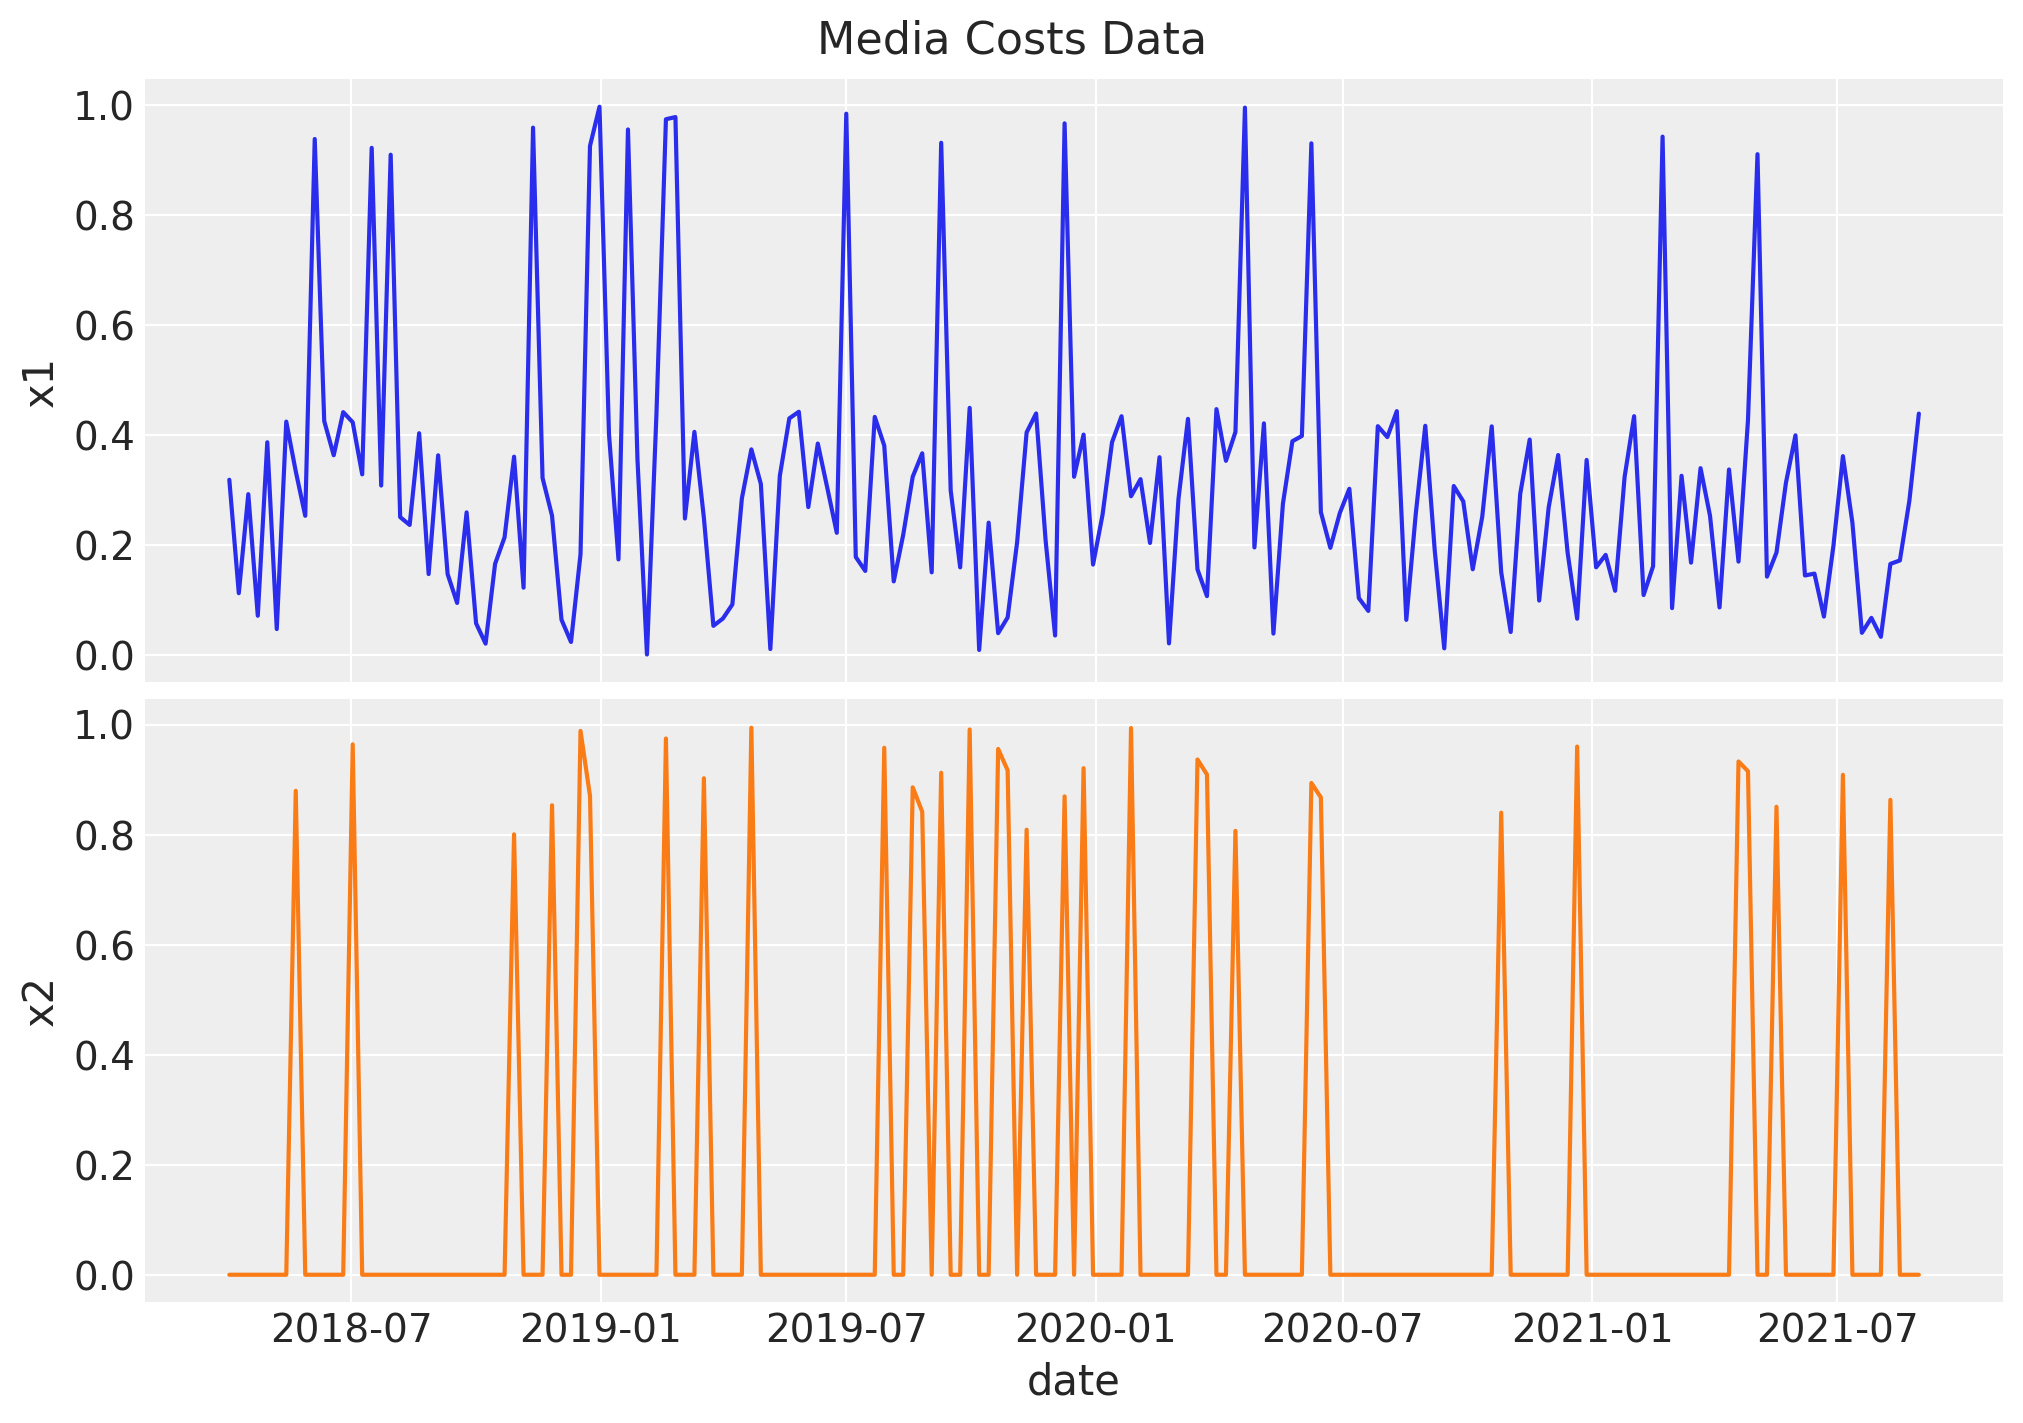

In [5]:
# media data
x1 = rng.uniform(low=0.0, high=1.0, size=n)
df["x1"] = np.where(x1 > 0.9, x1, x1 / 2)

x2 = rng.uniform(low=0.0, high=1.0, size=n)
df["x2"] = np.where(x2 > 0.8, x2, 0)


fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 7), sharex=True, sharey=True, layout="constrained"
)
sns.lineplot(x="date_week", y="x1", data=df, color="C0", ax=ax[0])
sns.lineplot(x="date_week", y="x2", data=df, color="C1", ax=ax[1])
ax[1].set(xlabel="date")
fig.suptitle("Media Costs Data", fontsize=16);


- Transformation to effect signals

In [6]:
# apply geometric adstock transformation
alpha1: float = 0.4
alpha2: float = 0.2

df["x1_adstock"] = (
    geometric_adstock(x=df["x1"].to_numpy(), alpha=alpha1, l_max=8, normalize=True)
    .eval()
    .flatten()
)

df["x2_adstock"] = (
    geometric_adstock(x=df["x2"].to_numpy(), alpha=alpha2, l_max=8, normalize=True)
    .eval()
    .flatten()
)


In [7]:
# apply saturation transformation
lam1: float = 4.0
lam2: float = 3.0

df["x1_adstock_saturated"] = logistic_saturation(
    x=df["x1_adstock"].to_numpy(), lam=lam1
).eval()

df["x2_adstock_saturated"] = logistic_saturation(
    x=df["x2_adstock"].to_numpy(), lam=lam2
).eval()


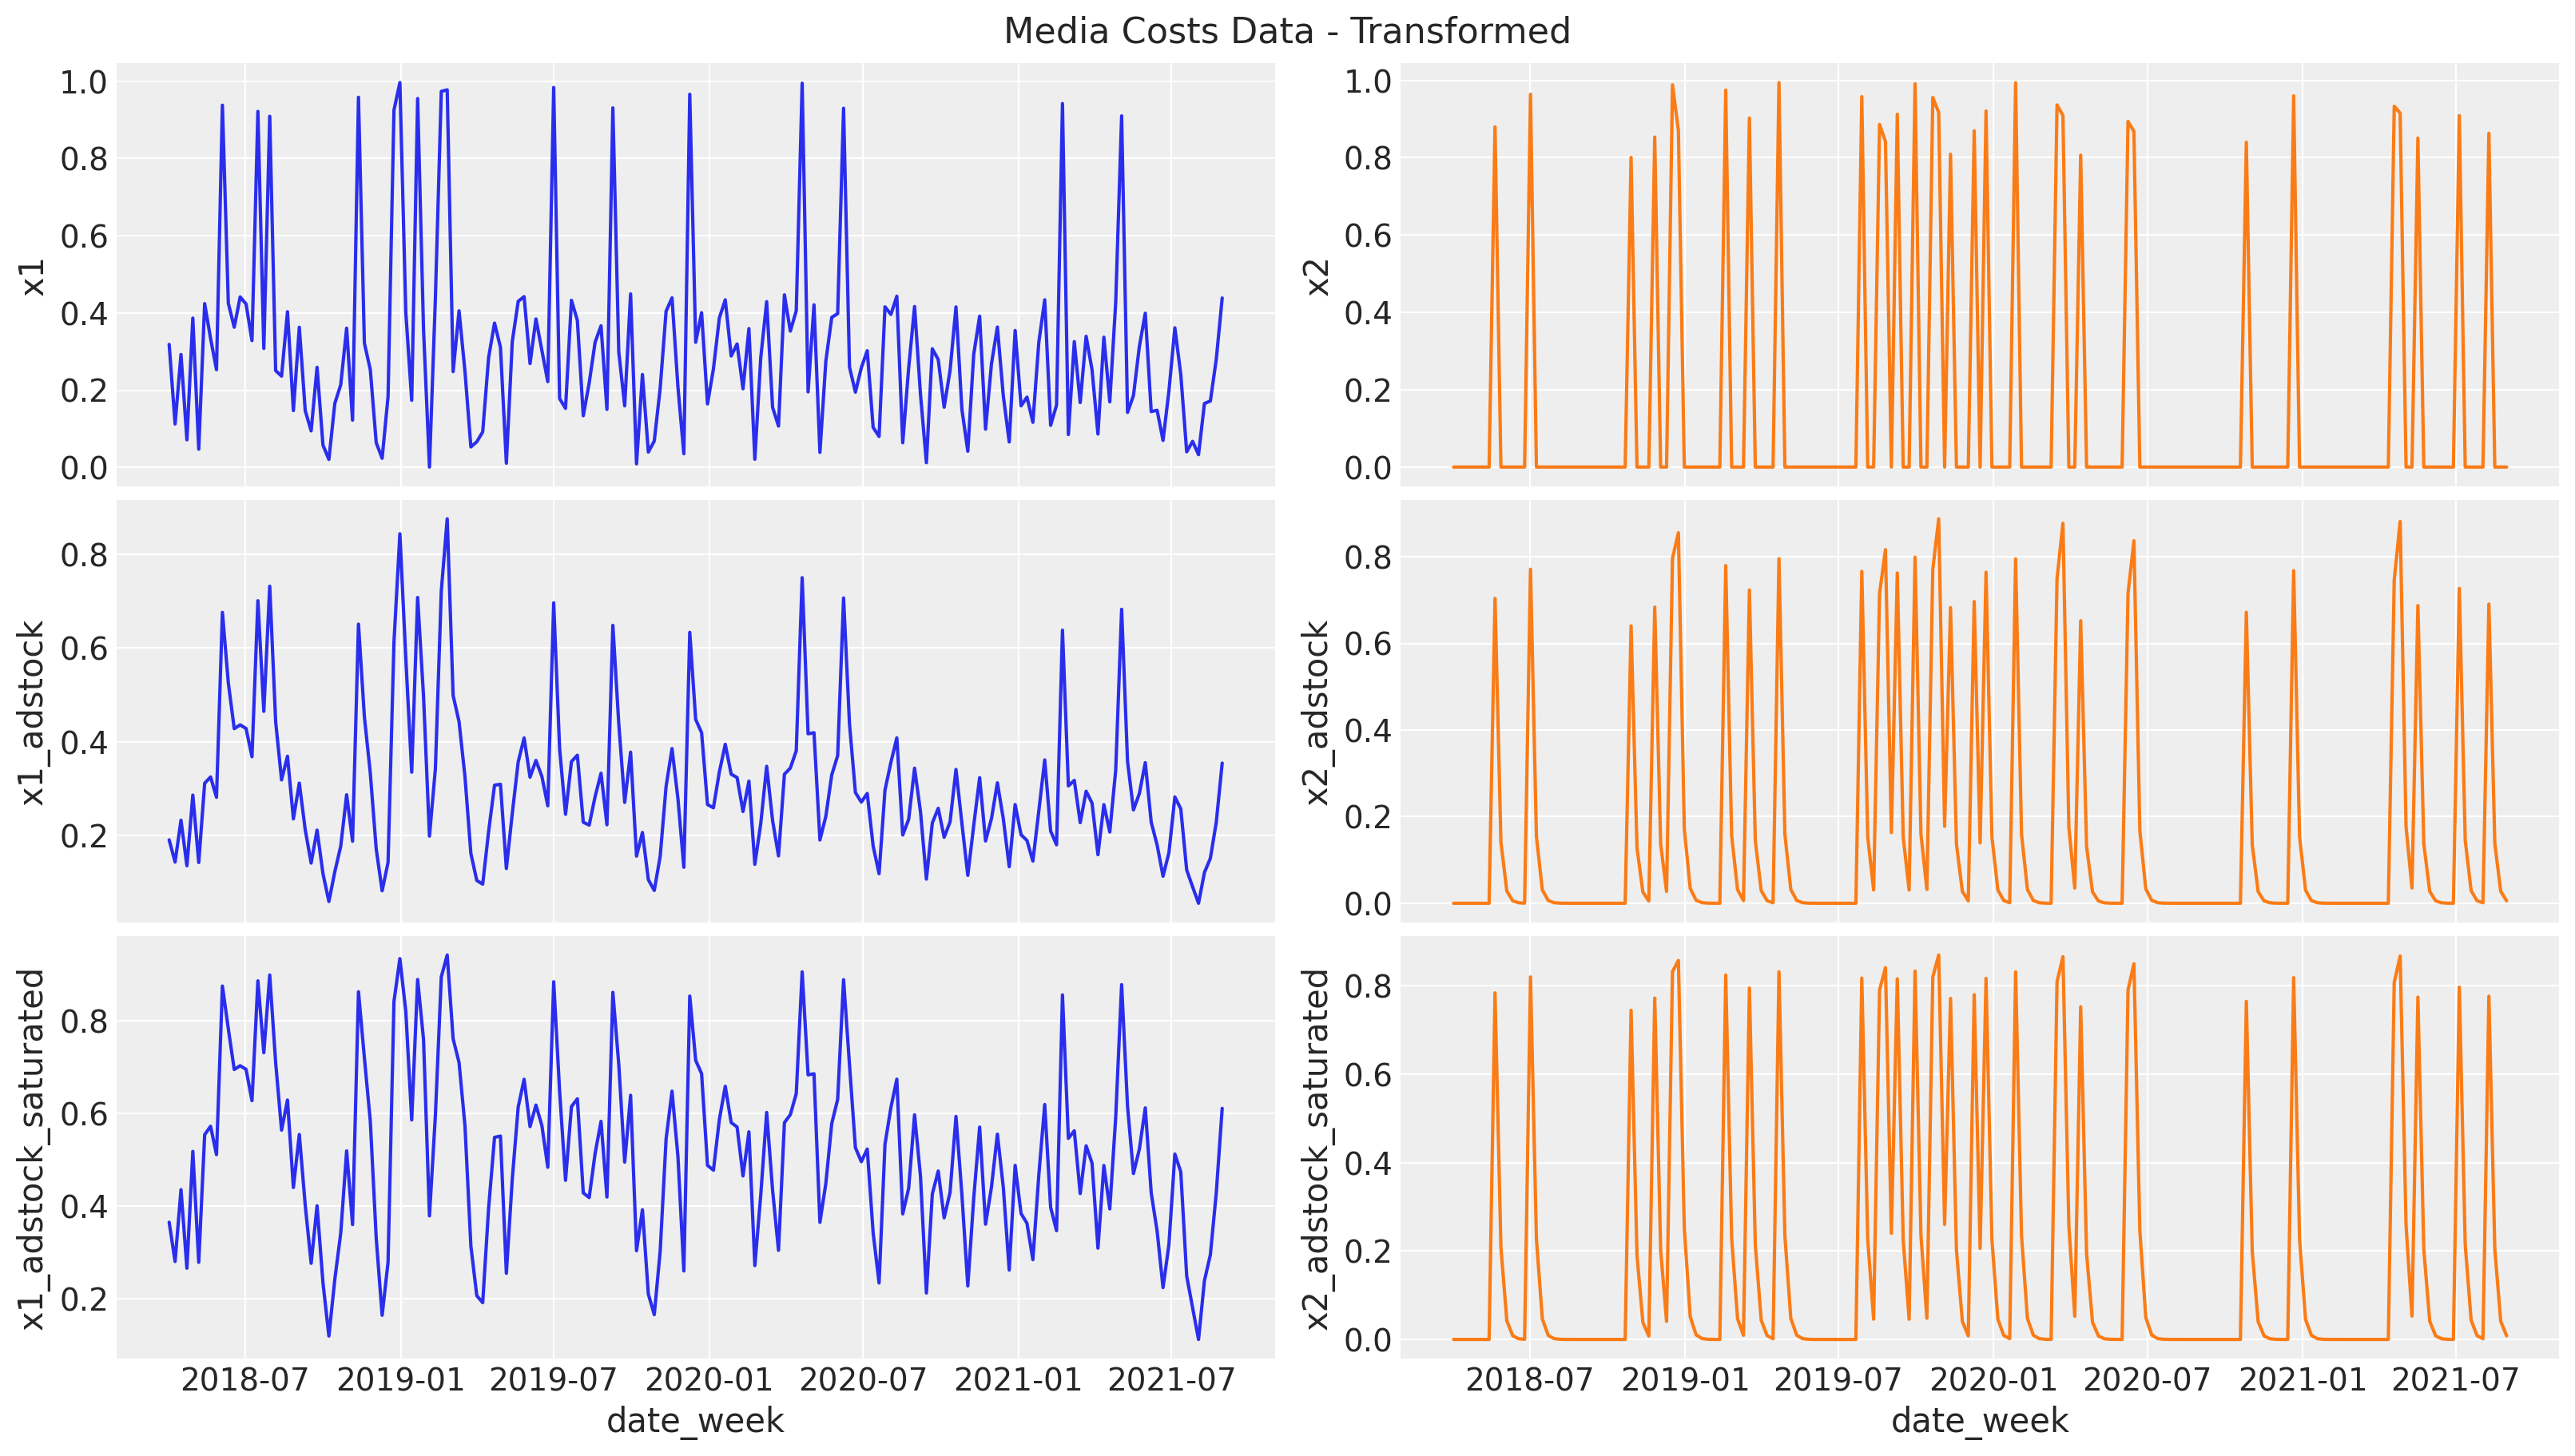

In [8]:
fig, ax = plt.subplots(
    nrows=3, ncols=2, figsize=(16, 9), sharex=True, sharey=False, layout="constrained"
)
sns.lineplot(x="date_week", y="x1", data=df, color="C0", ax=ax[0, 0])
sns.lineplot(x="date_week", y="x2", data=df, color="C1", ax=ax[0, 1])
sns.lineplot(x="date_week", y="x1_adstock", data=df, color="C0", ax=ax[1, 0])
sns.lineplot(x="date_week", y="x2_adstock", data=df, color="C1", ax=ax[1, 1])
sns.lineplot(x="date_week", y="x1_adstock_saturated", data=df, color="C0", ax=ax[2, 0])
sns.lineplot(x="date_week", y="x2_adstock_saturated", data=df, color="C1", ax=ax[2, 1])
fig.suptitle("Media Costs Data - Transformed", fontsize=16);


### 3. Trend & Seasonal Components

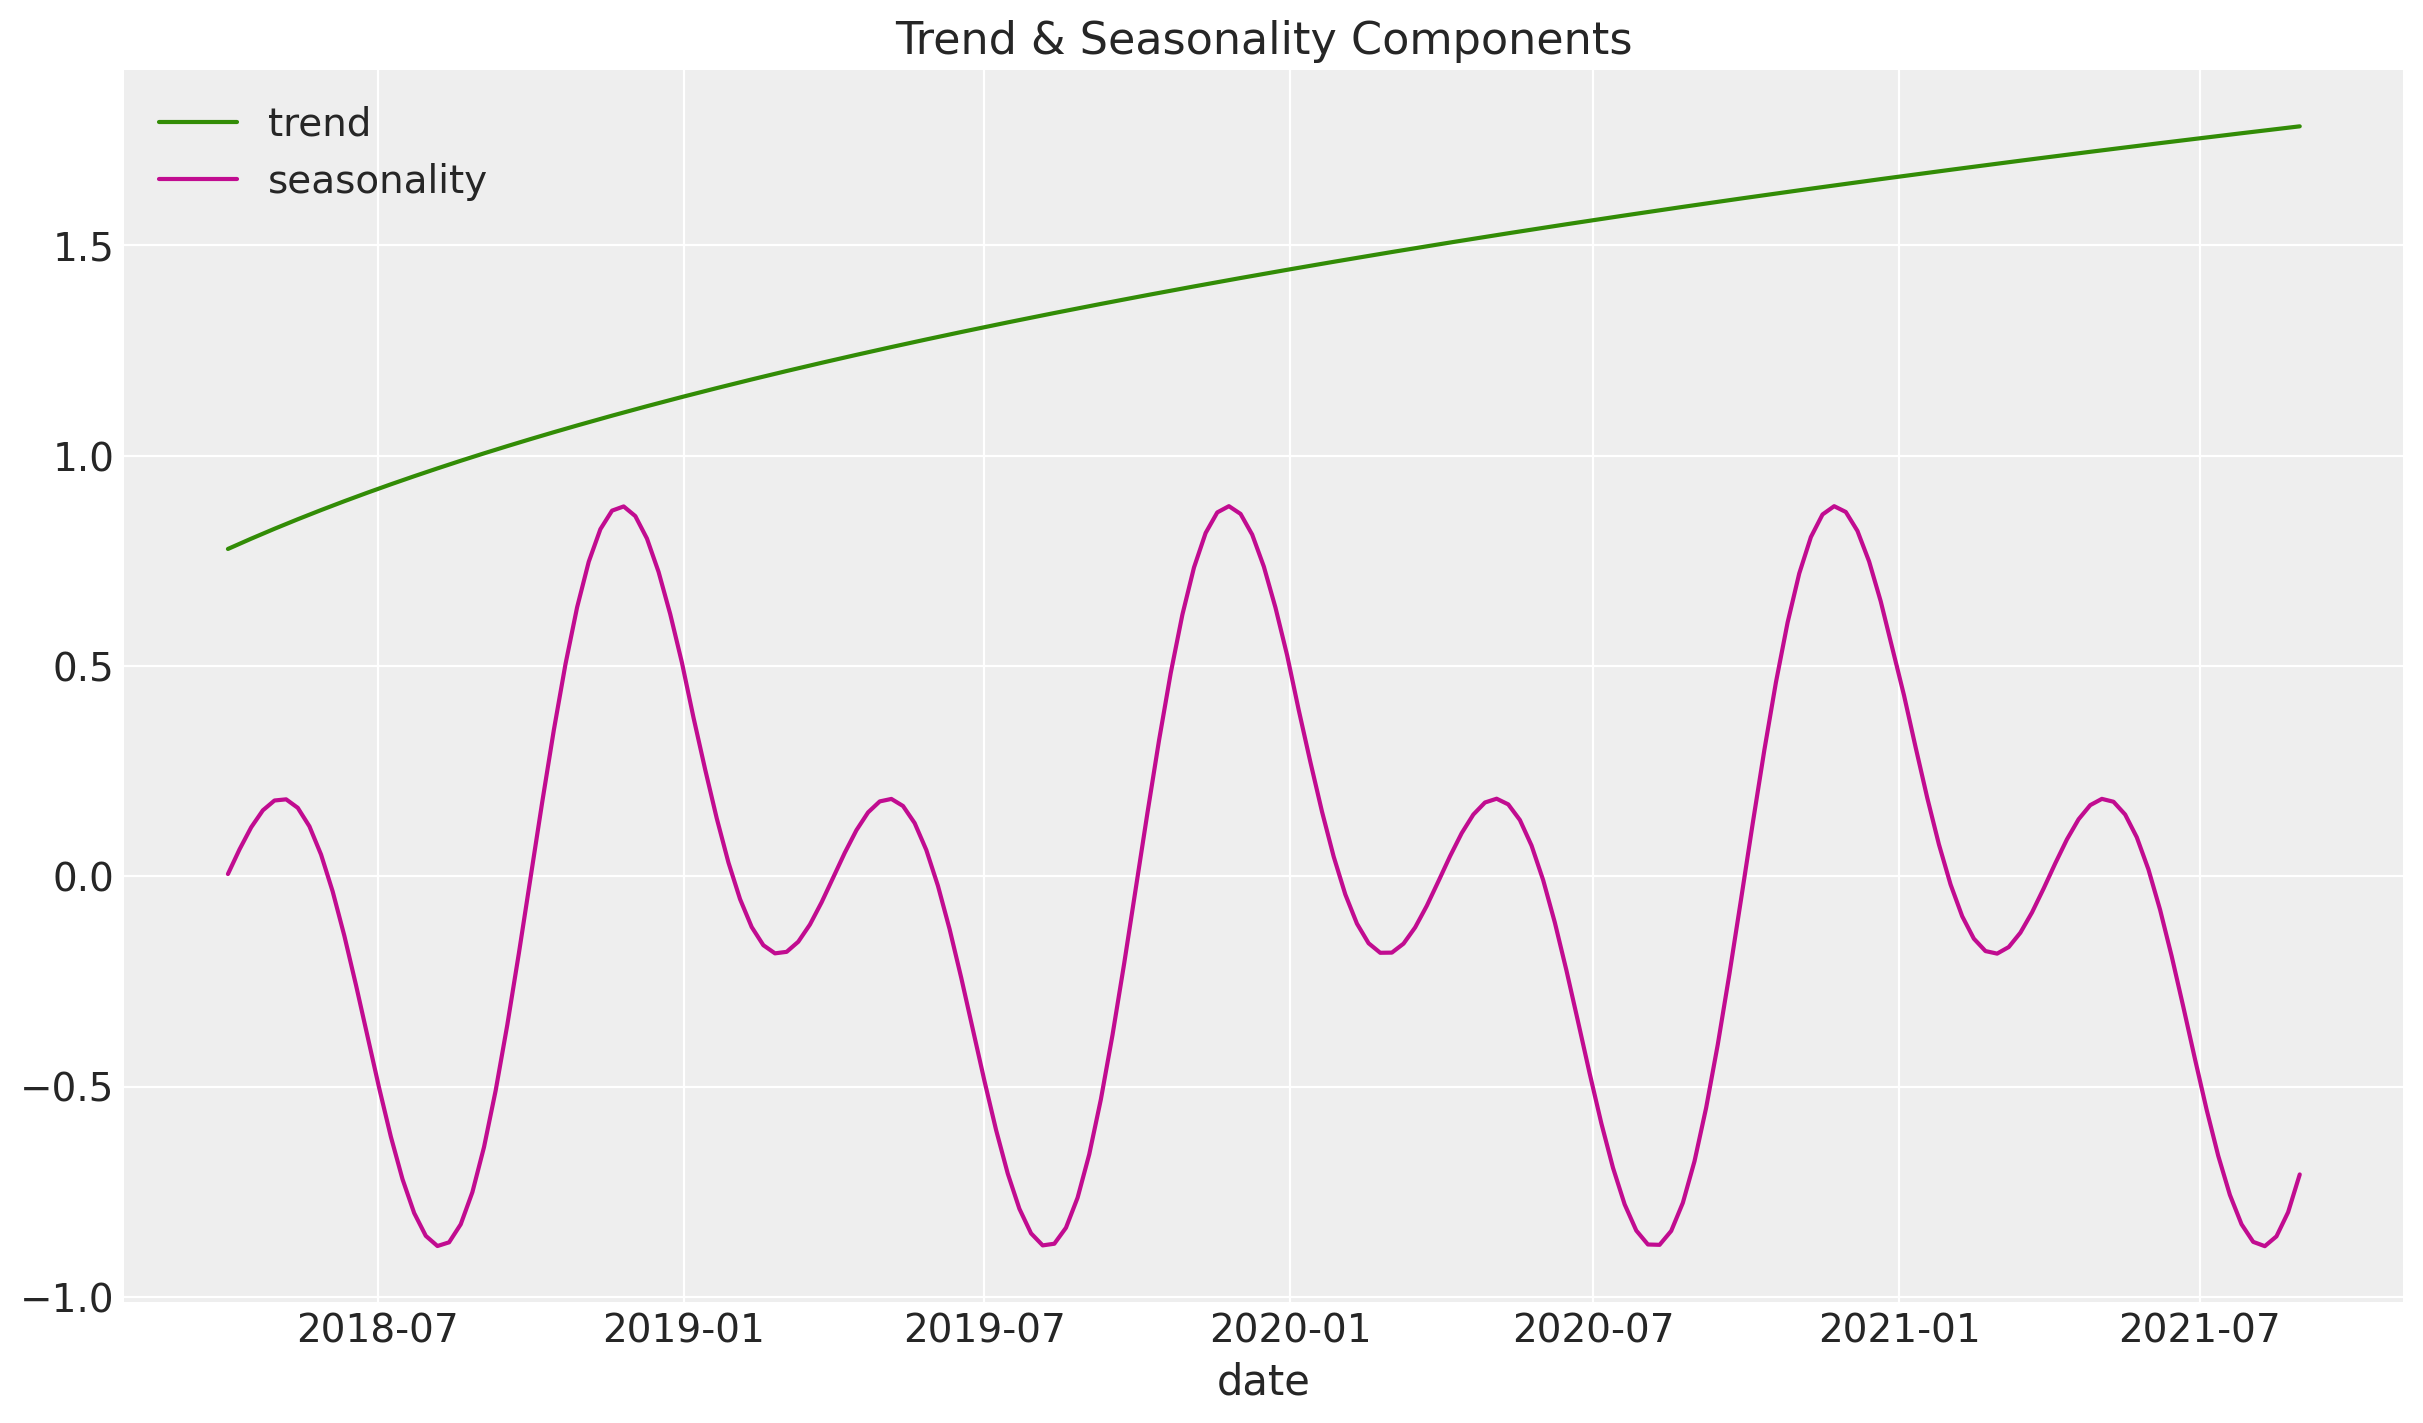

In [9]:
df["trend"] = (np.linspace(start=0.0, stop=50, num=n) + 10) ** (1 / 4) - 1

df["cs"] = -np.sin(2 * 2 * np.pi * df["dayofyear"] / 365.5)
df["cc"] = np.cos(1 * 2 * np.pi * df["dayofyear"] / 365.5)
df["seasonality"] = 0.5 * (df["cs"] + df["cc"])

fig, ax = plt.subplots()
sns.lineplot(x="date_week", y="trend", color="C2", label="trend", data=df, ax=ax)
sns.lineplot(
    x="date_week", y="seasonality", color="C3", label="seasonality", data=df, ax=ax
)
ax.legend(loc="upper left")
ax.set(title="Trend & Seasonality Components", xlabel="date", ylabel=None);


### 4. Control Variables

In [10]:
df["event_1"] = (df["date_week"] == "2019-05-13").astype(float)
df["event_2"] = (df["date_week"] == "2020-09-14").astype(float)


### 5. Target Variable

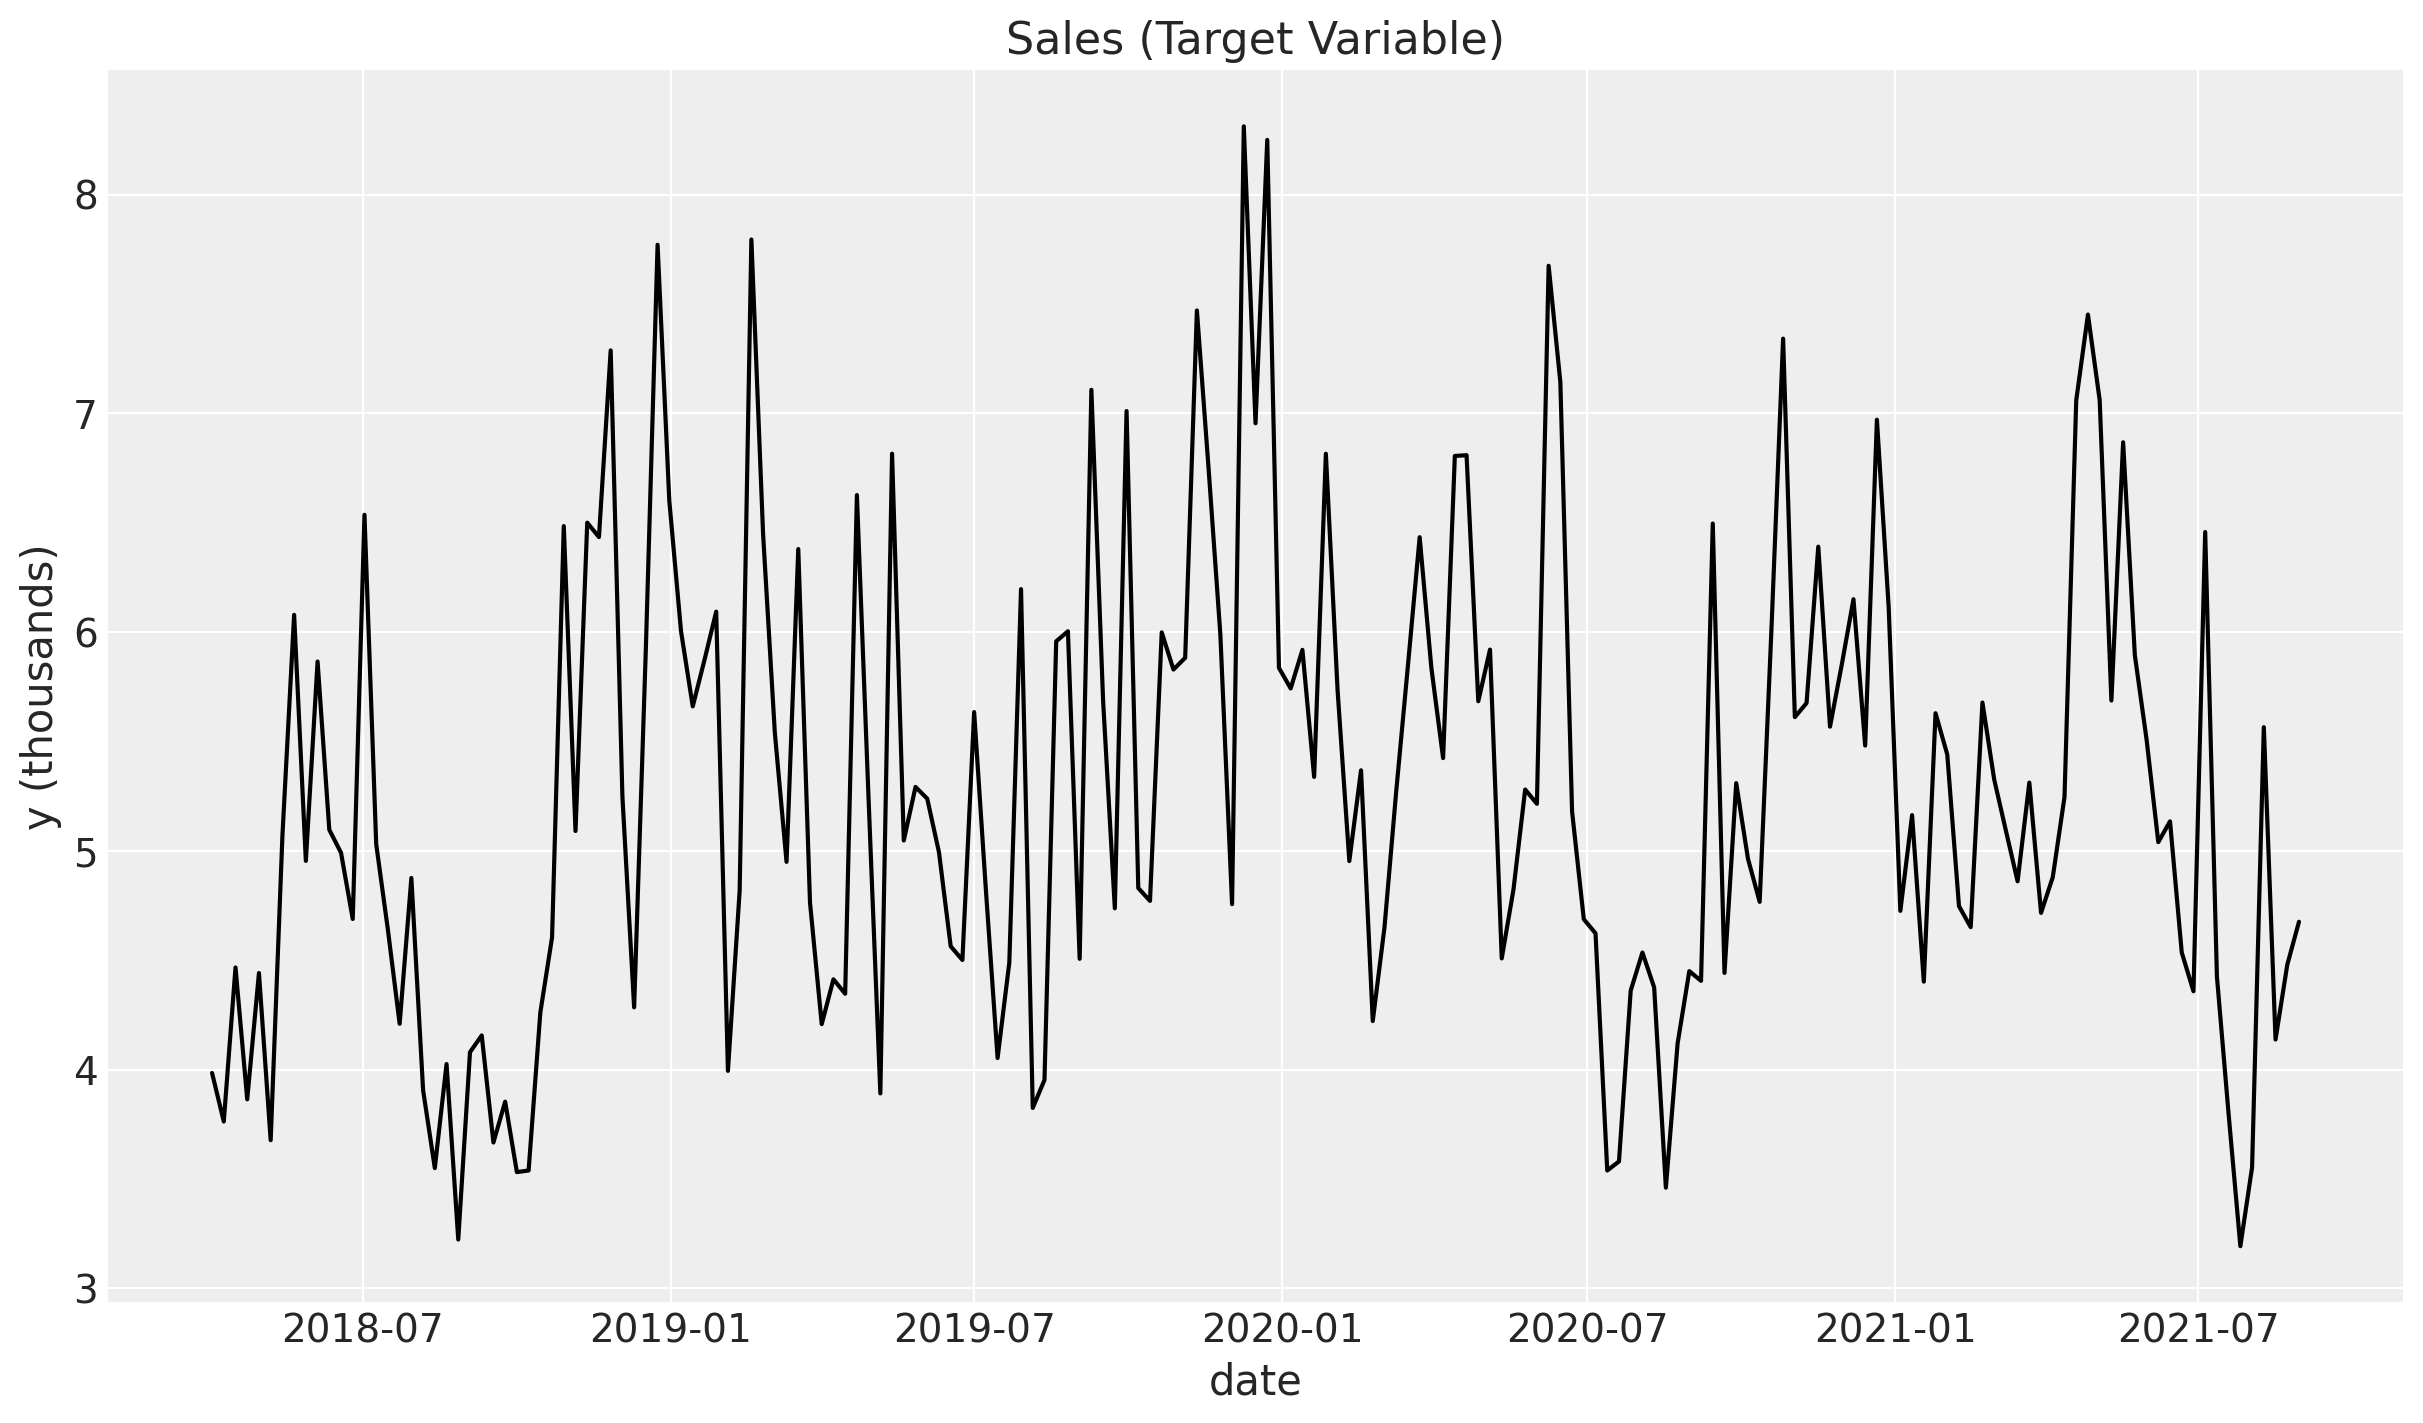

In [11]:
df["intercept"] = 2.0
df["epsilon"] = rng.normal(loc=0.0, scale=0.25, size=n)

amplitude = 1
beta_1 = 3.0
beta_2 = 2.0
betas = [beta_1, beta_2]


df["y"] = amplitude * (
    df["intercept"]
    + df["trend"]
    + df["seasonality"]
    + 1.5 * df["event_1"]
    + 2.5 * df["event_2"]
    + beta_1 * df["x1_adstock_saturated"]
    + beta_2 * df["x2_adstock_saturated"]
    + df["epsilon"]
)

fig, ax = plt.subplots()
sns.lineplot(x="date_week", y="y", color="black", data=df, ax=ax)
ax.set(title="Sales (Target Variable)", xlabel="date", ylabel="y (thousands)");


### 6. Media Contribution Interpretation

In [12]:
contribution_share_x1: float = (beta_1 * df["x1_adstock_saturated"]).sum() / (
    beta_1 * df["x1_adstock_saturated"] + beta_2 * df["x2_adstock_saturated"]
).sum()

contribution_share_x2: float = (beta_2 * df["x2_adstock_saturated"]).sum() / (
    beta_1 * df["x1_adstock_saturated"] + beta_2 * df["x2_adstock_saturated"]
).sum()

print(f"Contribution Share of x1: {contribution_share_x1:.2f}")
print(f"Contribution Share of x2: {contribution_share_x2:.2f}")


Contribution Share of x1: 0.81
Contribution Share of x2: 0.19


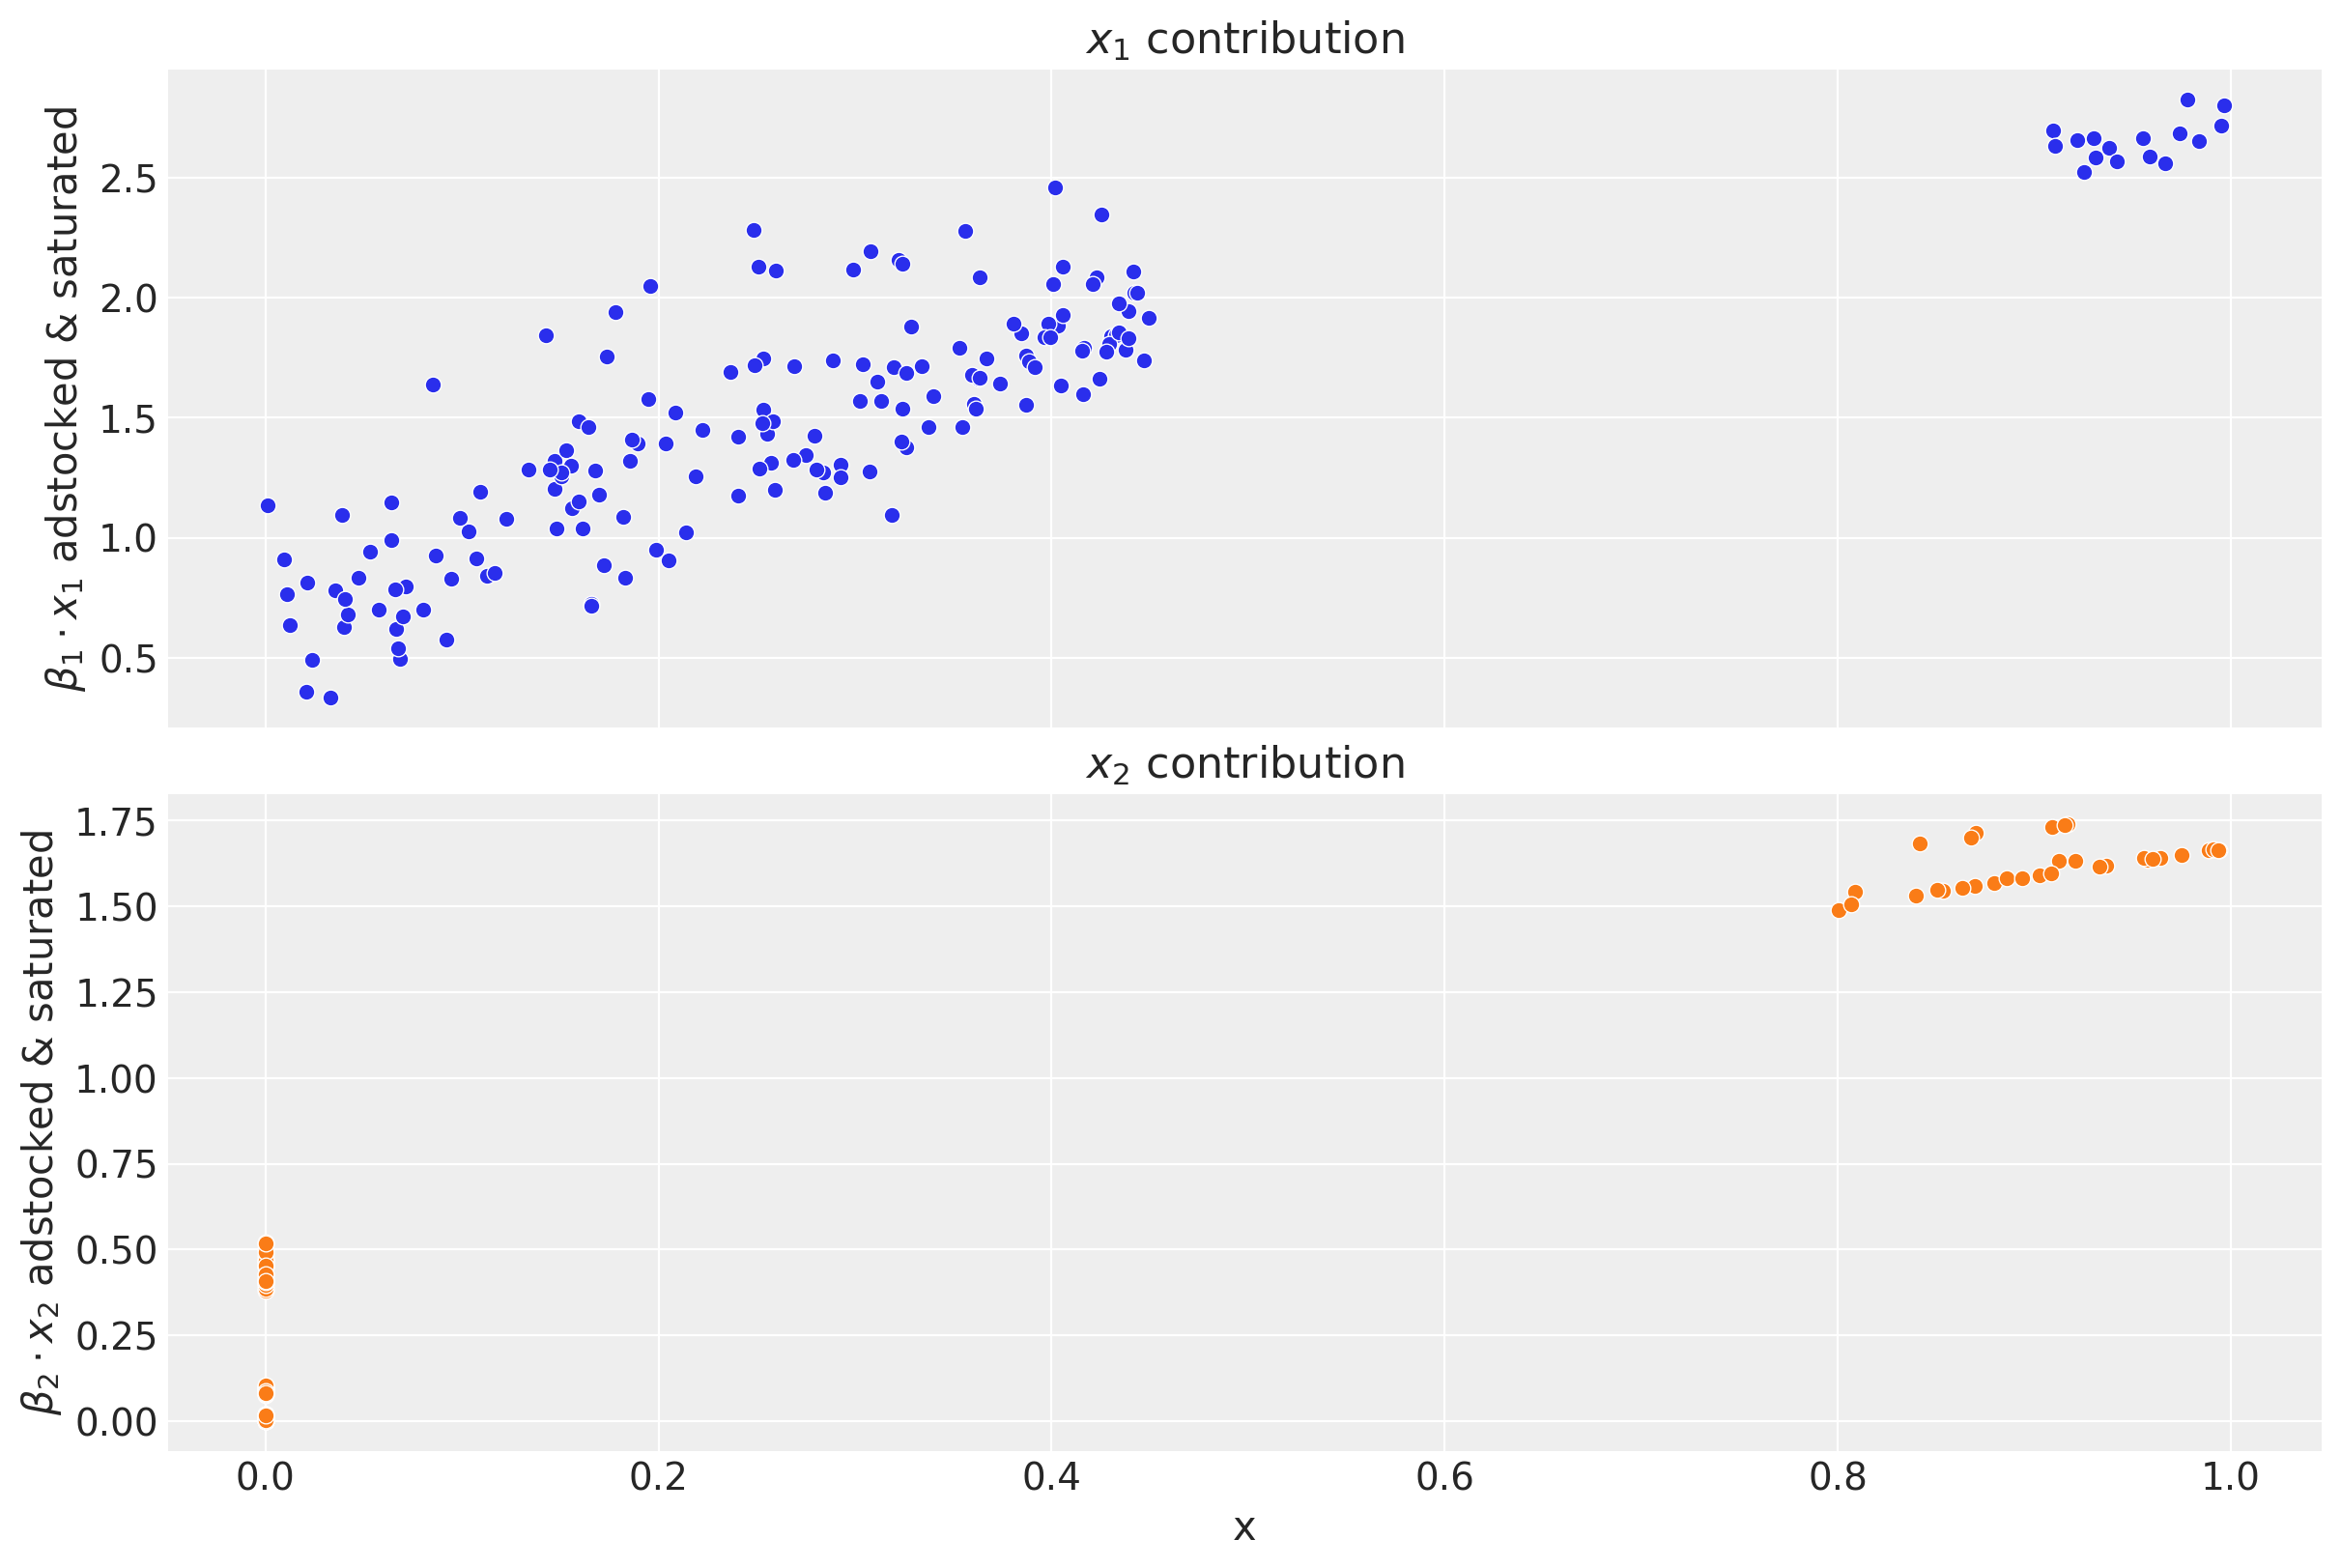

In [13]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 8), sharex=True, sharey=False, layout="constrained"
)

for i, x in enumerate(["x1", "x2"]):
    sns.scatterplot(
        x=df[x],
        y=amplitude * betas[i] * df[f"{x}_adstock_saturated"],
        color=f"C{i}",
        ax=ax[i],
    )
    ax[i].set(
        title=f"$x_{i + 1}$ contribution",
        ylabel=f"$\\beta_{i + 1} \cdot x_{i + 1}$ adstocked & saturated",
        xlabel="x",
    )
    

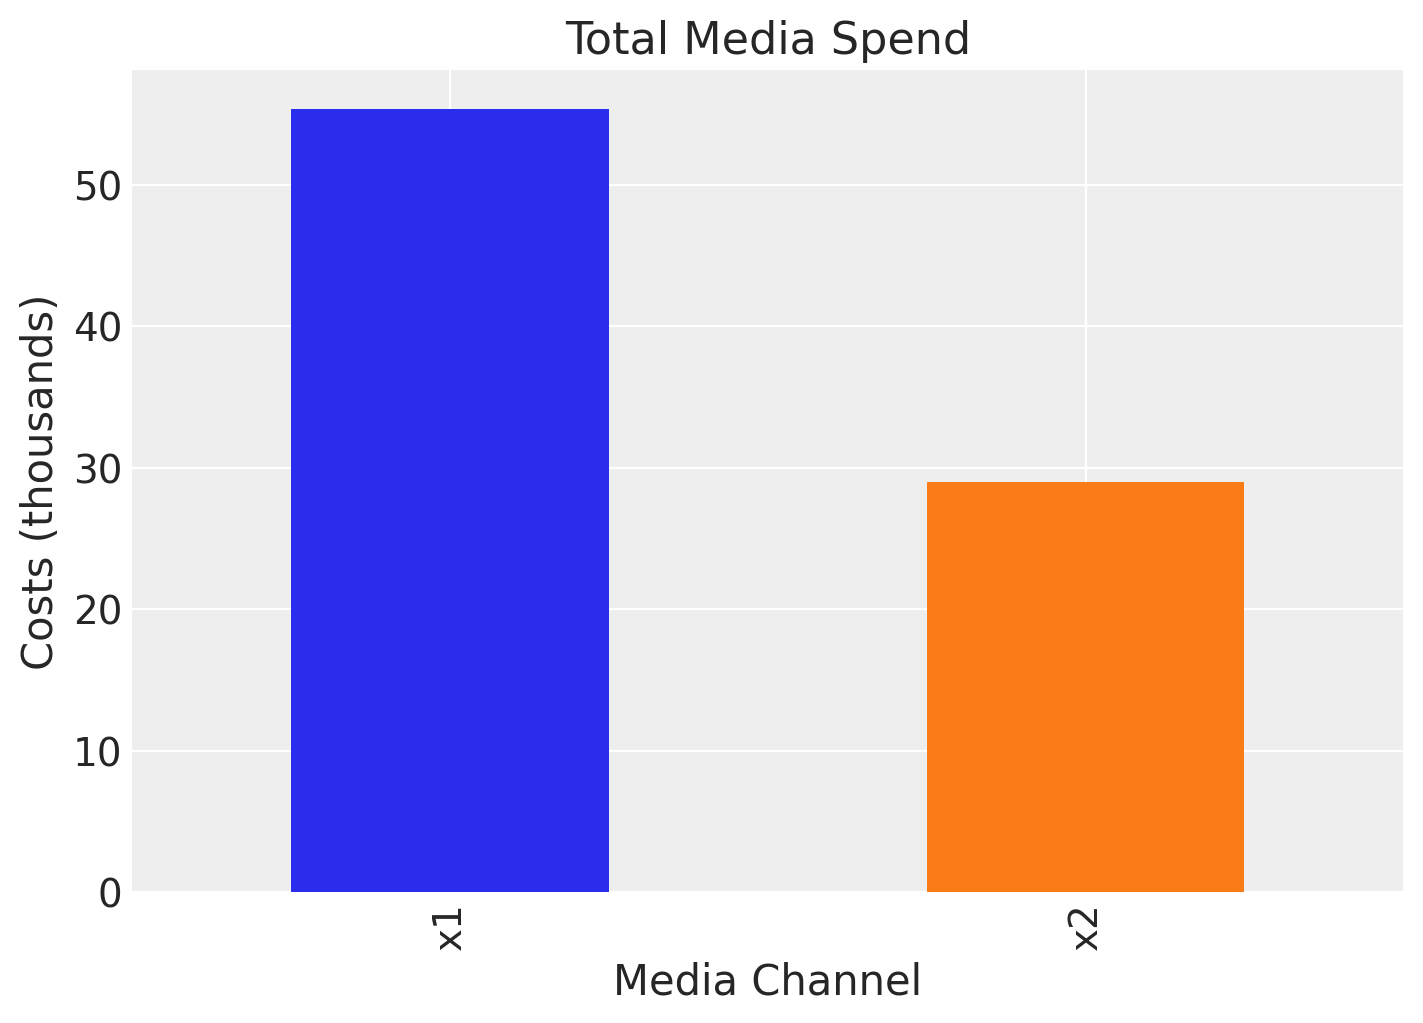

In [14]:
fig, ax = plt.subplots(figsize=(7, 5))
df[["x1", "x2"]].sum().plot(kind="bar", color=["C0", "C1"], ax=ax)
ax.set(title="Total Media Spend", xlabel="Media Channel", ylabel="Costs (thousands)");


In [15]:
roas_1 = (amplitude * beta_1 * df["x1_adstock_saturated"]).sum() / df["x1"].sum()
roas_2 = (amplitude * beta_2 * df["x2_adstock_saturated"]).sum() / df["x2"].sum()


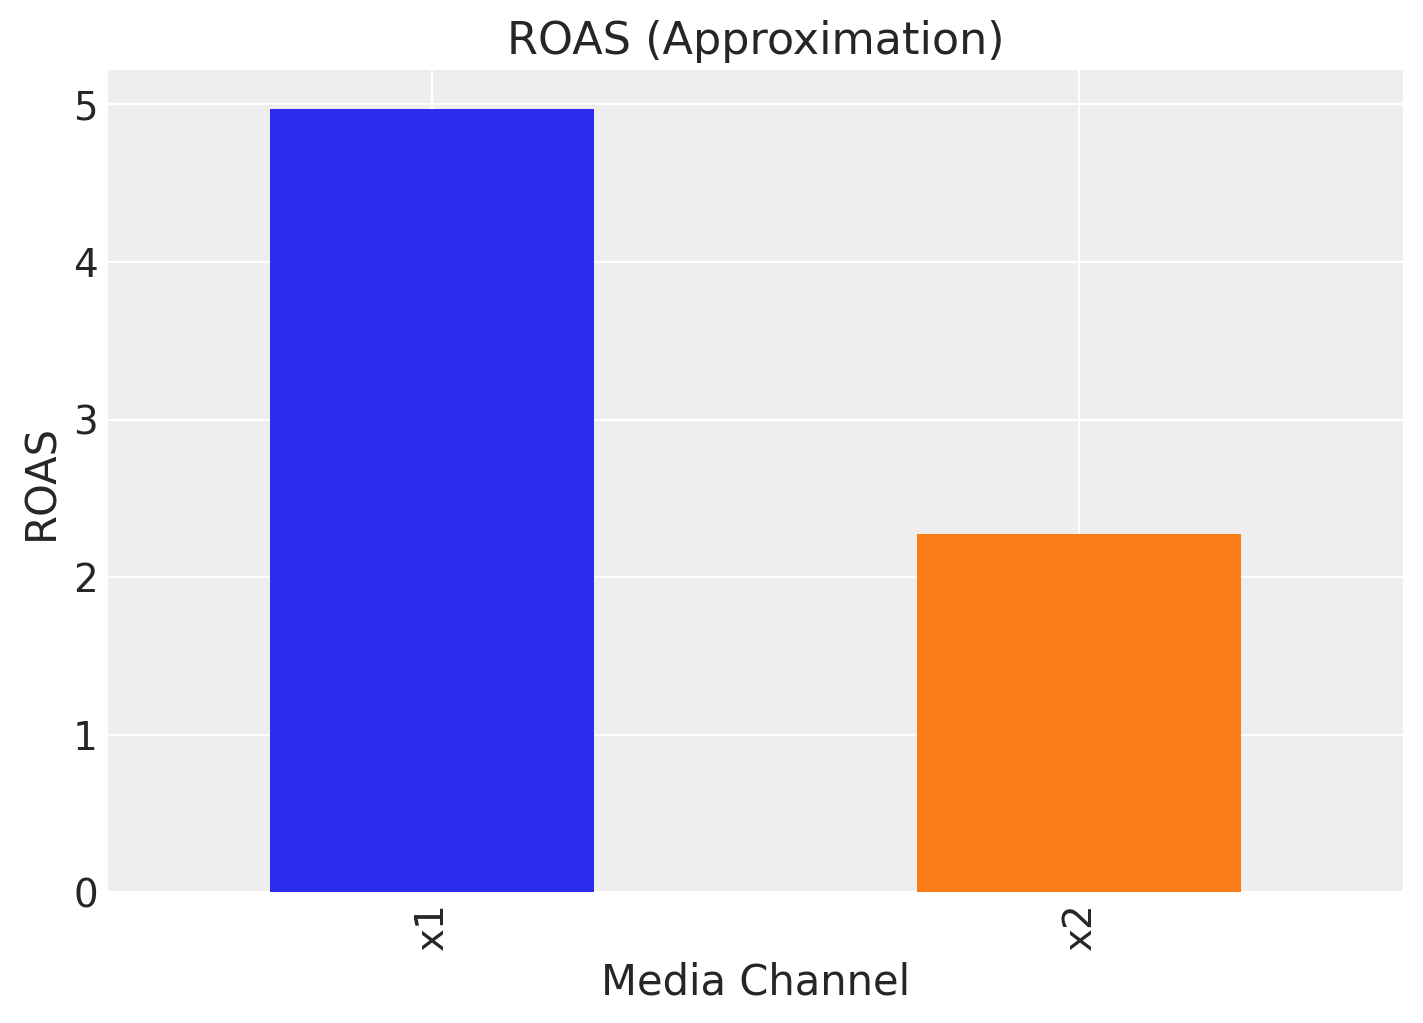

In [16]:
fig, ax = plt.subplots(figsize=(7, 5))
(
    pd.Series(data=[roas_1, roas_2], index=["x1", "x2"]).plot(
        kind="bar", color=["C0", "C1"]
    )
)

ax.set(title="ROAS (Approximation)", xlabel="Media Channel", ylabel="ROAS");


### 7. Data Output

In [17]:
columns_to_keep = [
    "date_week",
    "y",
    "x1",
    "x2",
    "event_1",
    "event_2",
    "dayofyear",
]

data = df[columns_to_keep].copy()

data.head()


date_week         y        x1   x2  event_1  event_2  dayofyear
0 2018-04-02  3.984662  0.318580  0.0      0.0      0.0         92
1 2018-04-09  3.762872  0.112388  0.0      0.0      0.0         99
2 2018-04-16  4.466967  0.292400  0.0      0.0      0.0        106
3 2018-04-23  3.864219  0.071399  0.0      0.0      0.0        113
4 2018-04-30  4.441625  0.386745  0.0      0.0      0.0        120

## Modeling

### 1. Feature Engineering

In [18]:
# trend feature
data["t"] = range(n)

data.head()


date_week         y        x1   x2  event_1  event_2  dayofyear  t
0 2018-04-02  3.984662  0.318580  0.0      0.0      0.0         92  0
1 2018-04-09  3.762872  0.112388  0.0      0.0      0.0         99  1
2 2018-04-16  4.466967  0.292400  0.0      0.0      0.0        106  2
3 2018-04-23  3.864219  0.071399  0.0      0.0      0.0        113  3
4 2018-04-30  4.441625  0.386745  0.0      0.0      0.0        120  4

### 2. Model Specification

In [19]:
total_spend_per_channel = data[["x1", "x2"]].sum(axis=0)

spend_share = total_spend_per_channel / total_spend_per_channel.sum()

spend_share


x1    0.65632
x2    0.34368
dtype: float64

In [20]:
# The scale necessary to make a HalfNormal distribution have unit variance
HALFNORMAL_SCALE = 1 / np.sqrt(1 - 2 / np.pi)

n_channels = 2

prior_sigma = HALFNORMAL_SCALE * n_channels * spend_share.to_numpy()

prior_sigma.tolist()


[2.1775326025486734, 1.1402608773919387]

In [21]:
X = data.drop('y',axis=1)
y = data['y']


- Model configuration

In [22]:
dummy_model = DelayedSaturatedMMM(date_column = '', channel_columns= '', adstock_max_lag = 4)
dummy_model.default_model_config


{'intercept': {'mu': 0, 'sigma': 2},
 'beta_channel': {'sigma': 2, 'dims': ('channel',)},
 'alpha': {'alpha': 1, 'beta': 3, 'dims': ('channel',)},
 'lam': {'alpha': 3, 'beta': 1, 'dims': ('channel',)},
 'sigma': {'sigma': 2},
 'gamma_control': {'mu': 0, 'sigma': 2, 'dims': ('control',)},
 'mu': {'dims': ('date',)},
 'likelihood': {'dims': ('date',)},
 'gamma_fourier': {'mu': 0, 'b': 1, 'dims': 'fourier_mode'}}

In [23]:
custom_beta_channel_prior = {'beta_channel': {'sigma': prior_sigma, 'dims': ('channel',)}}
my_model_config = {**dummy_model.default_model_config, **custom_beta_channel_prior}


- Sampling configuration

In [24]:
sampler_config= {"progressbar": True}


In [25]:
mmm = DelayedSaturatedMMM(
    model_config = my_model_config,
    sampler_config = sampler_config,
    date_column="date_week",
    channel_columns=["x1", "x2"],
    control_columns=[
        "event_1",
        "event_2",
        "t",
    ],
    adstock_max_lag=8,
    yearly_seasonality=2,
)


### 3. Model Fitting

In [27]:
mmm.fit(X=X, y=y, target_accept=0.95, chains=4, random_seed=rng)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_channel, alpha, lam, sigma, gamma_control, gamma_fourier]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
Sampling: [alpha, beta_channel, gamma_control, gamma_fourier, intercept, lam, likelihood, sigma]
Sampling: [likelihood]


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data
	> fit_data

In [28]:
type(mmm.model)


pymc.model.Model

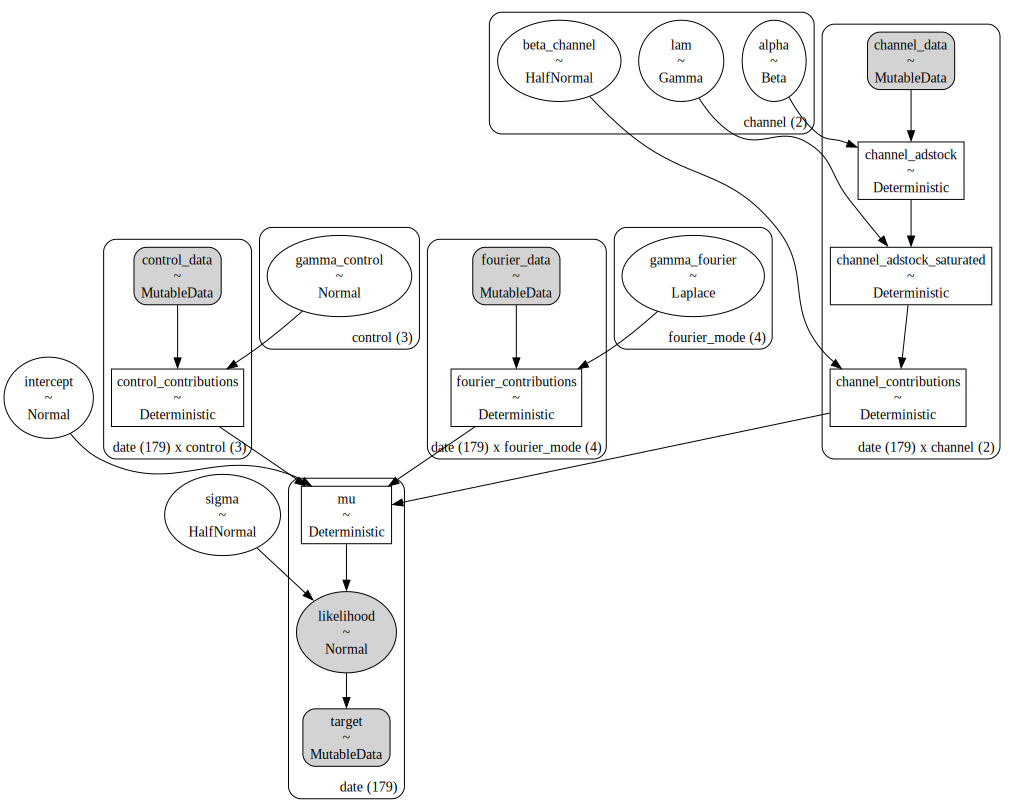

In [31]:
pm.model_to_graphviz(model=mmm.model)


### 4. Model Diagnostics

In [32]:
mmm.fit_result


<xarray.Dataset>
Dimensions:                    (chain: 4, draw: 1000, control: 3,
                                fourier_mode: 4, channel: 2, date: 179)
Coordinates:
  * chain                      (chain) int64 0 1 2 3
  * draw                       (draw) int64 0 1 2 3 4 5 ... 995 996 997 998 999
  * control                    (control) <U7 'event_1' 'event_2' 't'
  * fourier_mode               (fourier_mode) <U11 'sin_order_1' ... 'cos_ord...
  * channel                    (channel) <U2 'x1' 'x2'
  * date                       (date) datetime64[ns] 2018-04-02 ... 2021-08-30
Data variables: (12/13)
    intercept                  (chain, draw) float64 0.3721 0.3673 ... 0.3519
    gamma_control              (chain, draw, control) float64 0.2567 ... 0.00...
    gamma_fourier              (chain, draw, fourier_mode) float64 0.003193 ....
    beta_channel               (chain, draw, channel) float64 0.3582 ... 0.2147
    alpha                      (chain, draw, channel) float64 0.3422 ... 0.1402
    lam                        (chain, draw, channel) float64 3.584 ... 4.853
    ...                         ...
    channel_adstock            (chain, draw, date, channel) float64 0.2103 .....
    channel_adstock_saturated  (chain, draw, date, channel) float64 0.36 ... ...
    channel_contributions      (chain, draw, date, channel) float64 0.129 ......
    control_contributions      (chain, draw, date, control) float64 0.0 ... 0...
    fourier_contributions      (chain, draw, date, fourier_mode) float64 0.00...
    mu                         (chain, draw, date) float64 0.4964 ... 0.5925
Attributes:
    created_at:                 2023-08-20T21:05:16.857474
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.7.2
    sampling_time:              21.77184510231018
    tuning_steps:               1000

In [33]:
az.summary(
    data=mmm.fit_result,
    var_names=[
        "intercept",
        "beta_channel",
        "alpha",
        "lam",
        "gamma_control",
        "gamma_fourier",
        "sigma",
    ],
)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
intercept                   0.350  0.013   0.326    0.375      0.000    0.000   
beta_channel[x1]            0.362  0.018   0.327    0.397      0.000    0.000   
beta_channel[x2]            0.269  0.081   0.193    0.373      0.003    0.002   
alpha[x1]                   0.397  0.030   0.342    0.452      0.001    0.000   
alpha[x2]                   0.193  0.040   0.120    0.267      0.001    0.001   
lam[x1]                     4.069  0.367   3.369    4.739      0.006    0.004   
lam[x2]                     3.151  1.125   1.186    5.249      0.025    0.017   
gamma_control[event_1]      0.246  0.030   0.192    0.303      0.000    0.000   
gamma_control[event_2]      0.327  0.031   0.267    0.383      0.000    0.000   
gamma_control[t]            0.001  0.000   0.001    0.001      0.000    0.000   
gamma_fourier[sin_order_1]  0.003  0.003  -0.003    0.009      0.000    0.000   
gamma_fourier[cos_order_1]  0.063  0.003   0.057    0.069      0.000    0.000   
gamma_fourier[sin_order_2] -0.057  0.003  -0.064   -0.051      0.000    0.000   
gamma_fourier[cos_order_2]  0.002  0.004  -0.005    0.008      0.000    0.000   
sigma                       0.030  0.002   0.027    0.033      0.000    0.000   

                            ess_bulk  ess_tail  r_hat  
intercept                     2550.0    2652.0    1.0  
beta_channel[x1]              2227.0    2491.0    1.0  
beta_channel[x2]              1885.0    1300.0    1.0  
alpha[x1]                     2735.0    2864.0    1.0  
alpha[x2]                     2656.0    2216.0    1.0  
lam[x1]                       3368.0    2547.0    1.0  
lam[x2]                       1915.0    1265.0    1.0  
gamma_control[event_1]        5707.0    3185.0    1.0  
gamma_control[event_2]        5296.0    3039.0    1.0  
gamma_control[t]              3754.0    2639.0    1.0  
gamma_fourier[sin_order_1]    4057.0    2871.0    1.0  
gamma_fourier[cos_order_1]    5944.0    2649.0    1.0  
gamma_fourier[sin_order_2]    4745.0    3140.0    1.0  
gamma_fourier[cos_order_2]    4406.0    2712.0    1.0  
sigma                         4307.0    2805.0    1.0

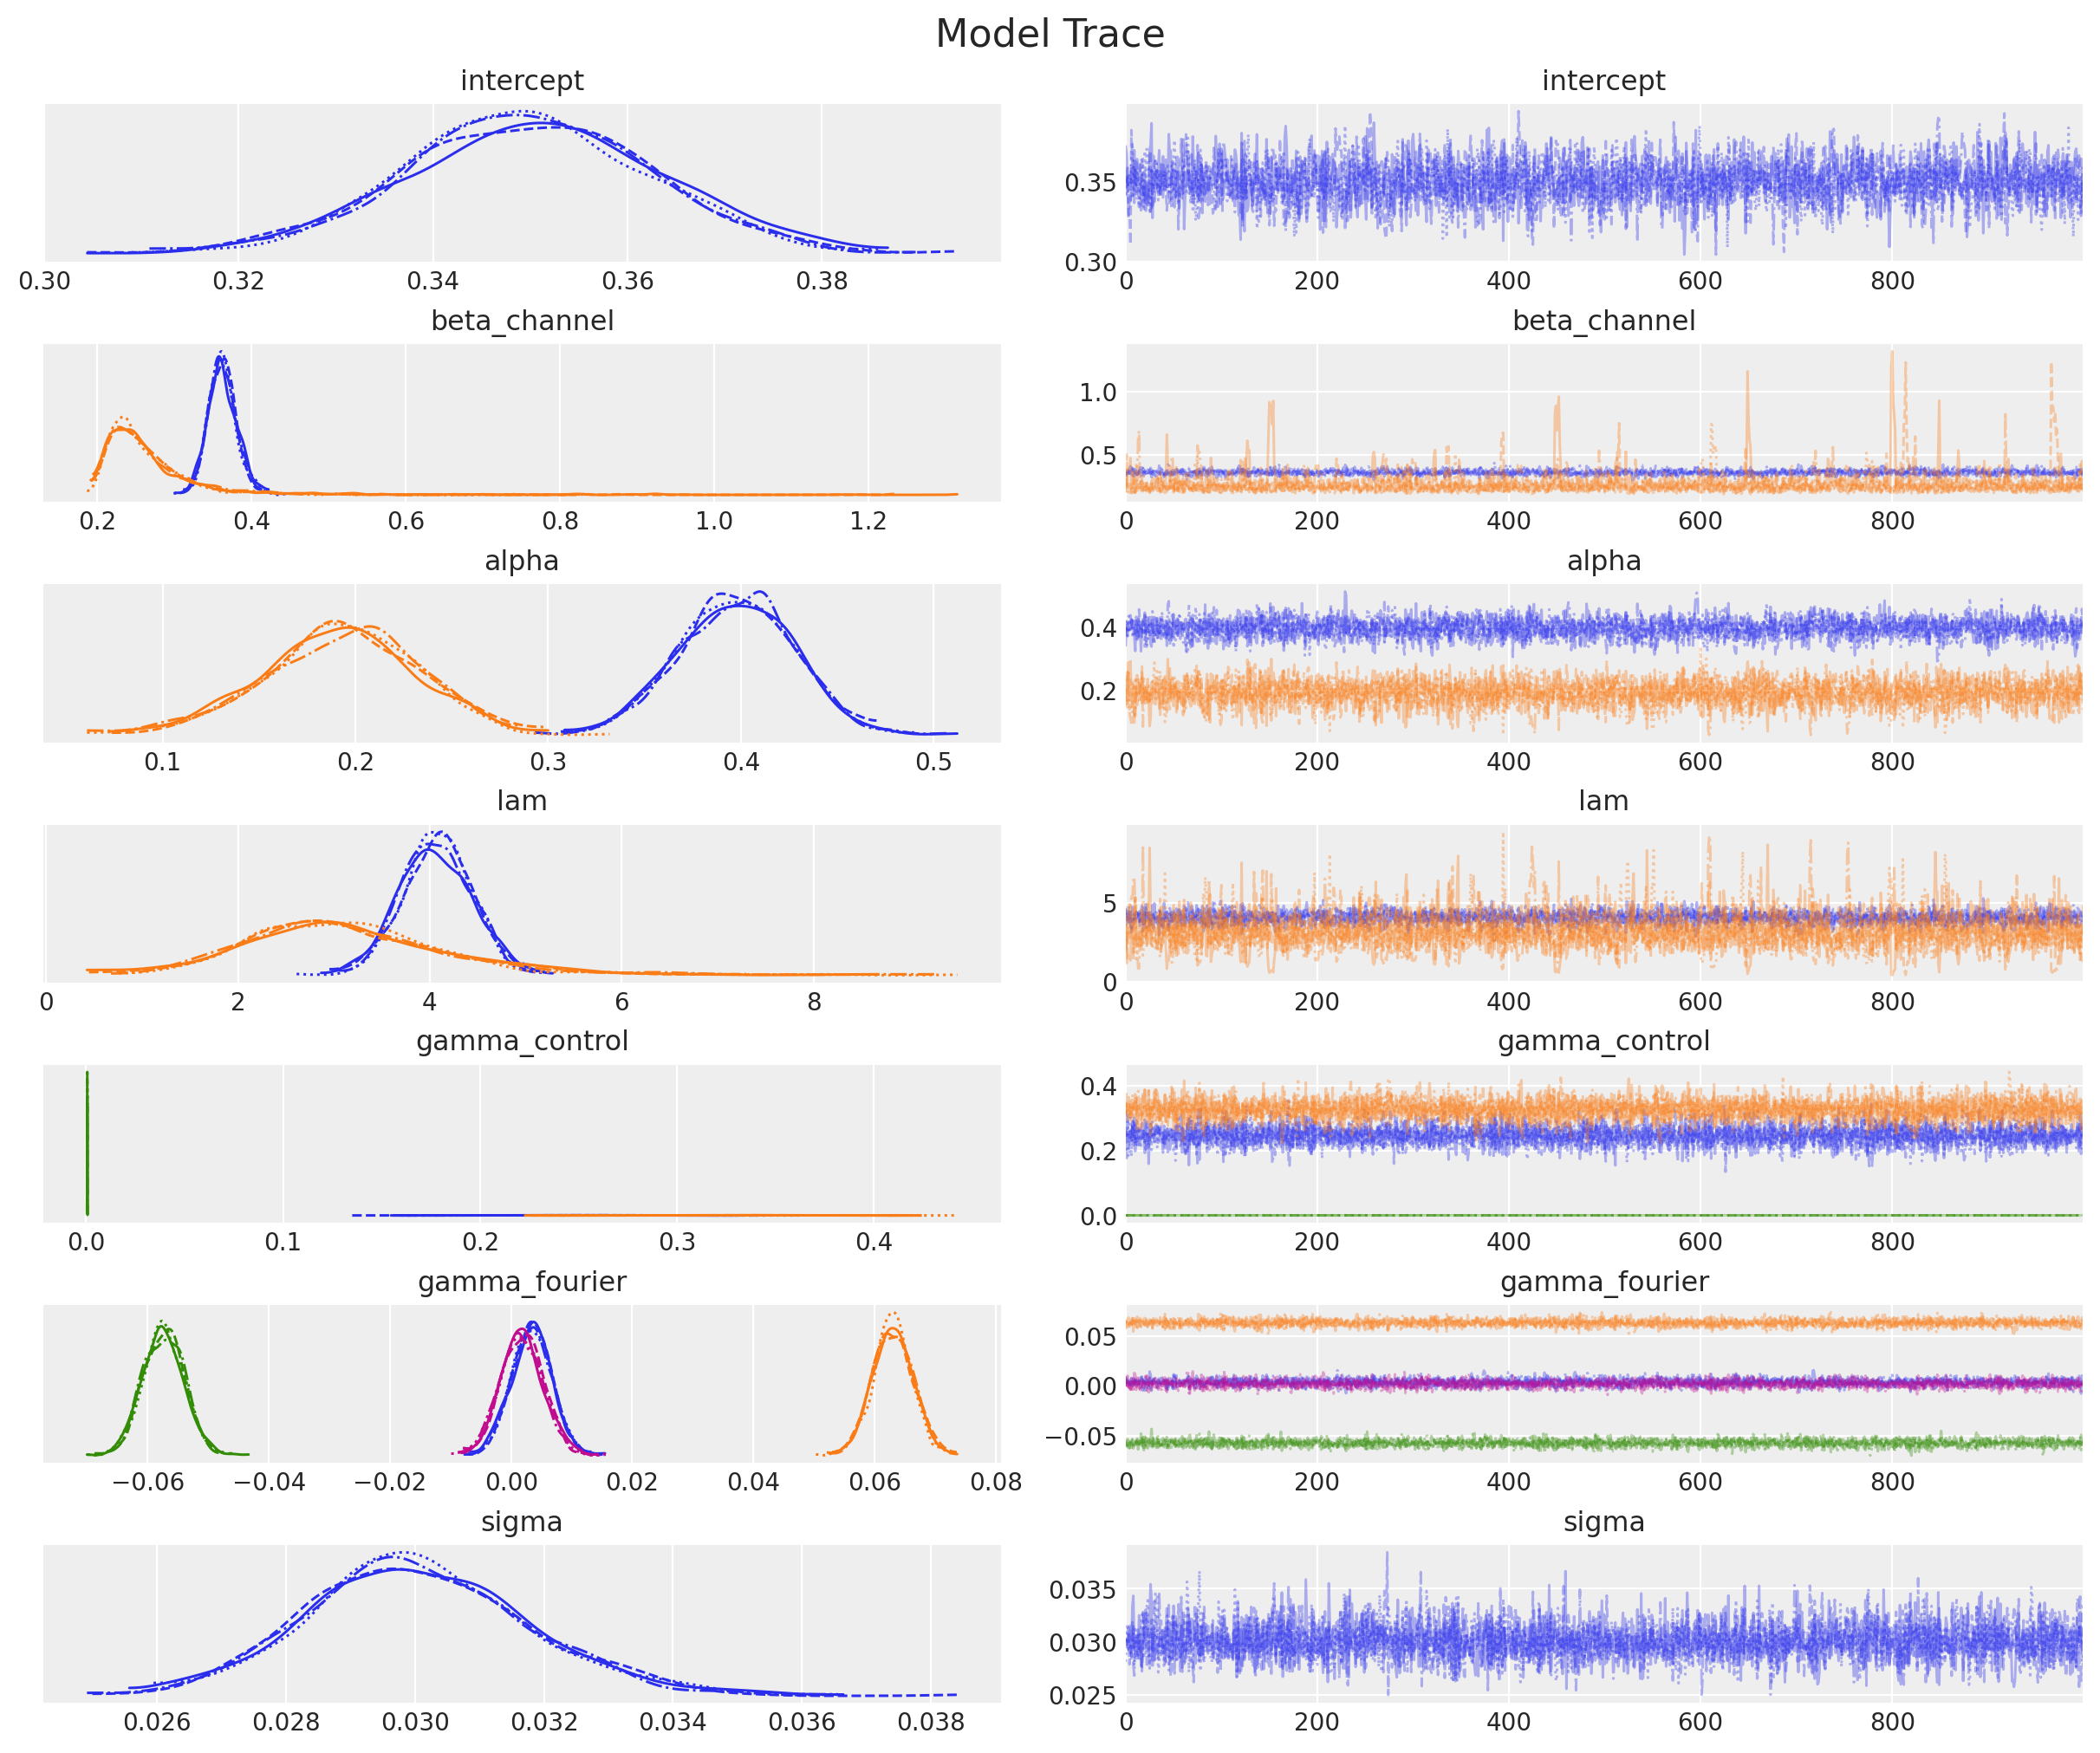

In [34]:
_ = az.plot_trace(
    data=mmm.fit_result,
    var_names=[
        "intercept",
        "beta_channel",
        "alpha",
        "lam",
        "gamma_control",
        "gamma_fourier",
        "sigma",
    ],
    compact=True,
    backend_kwargs={"figsize": (12, 10), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=16);


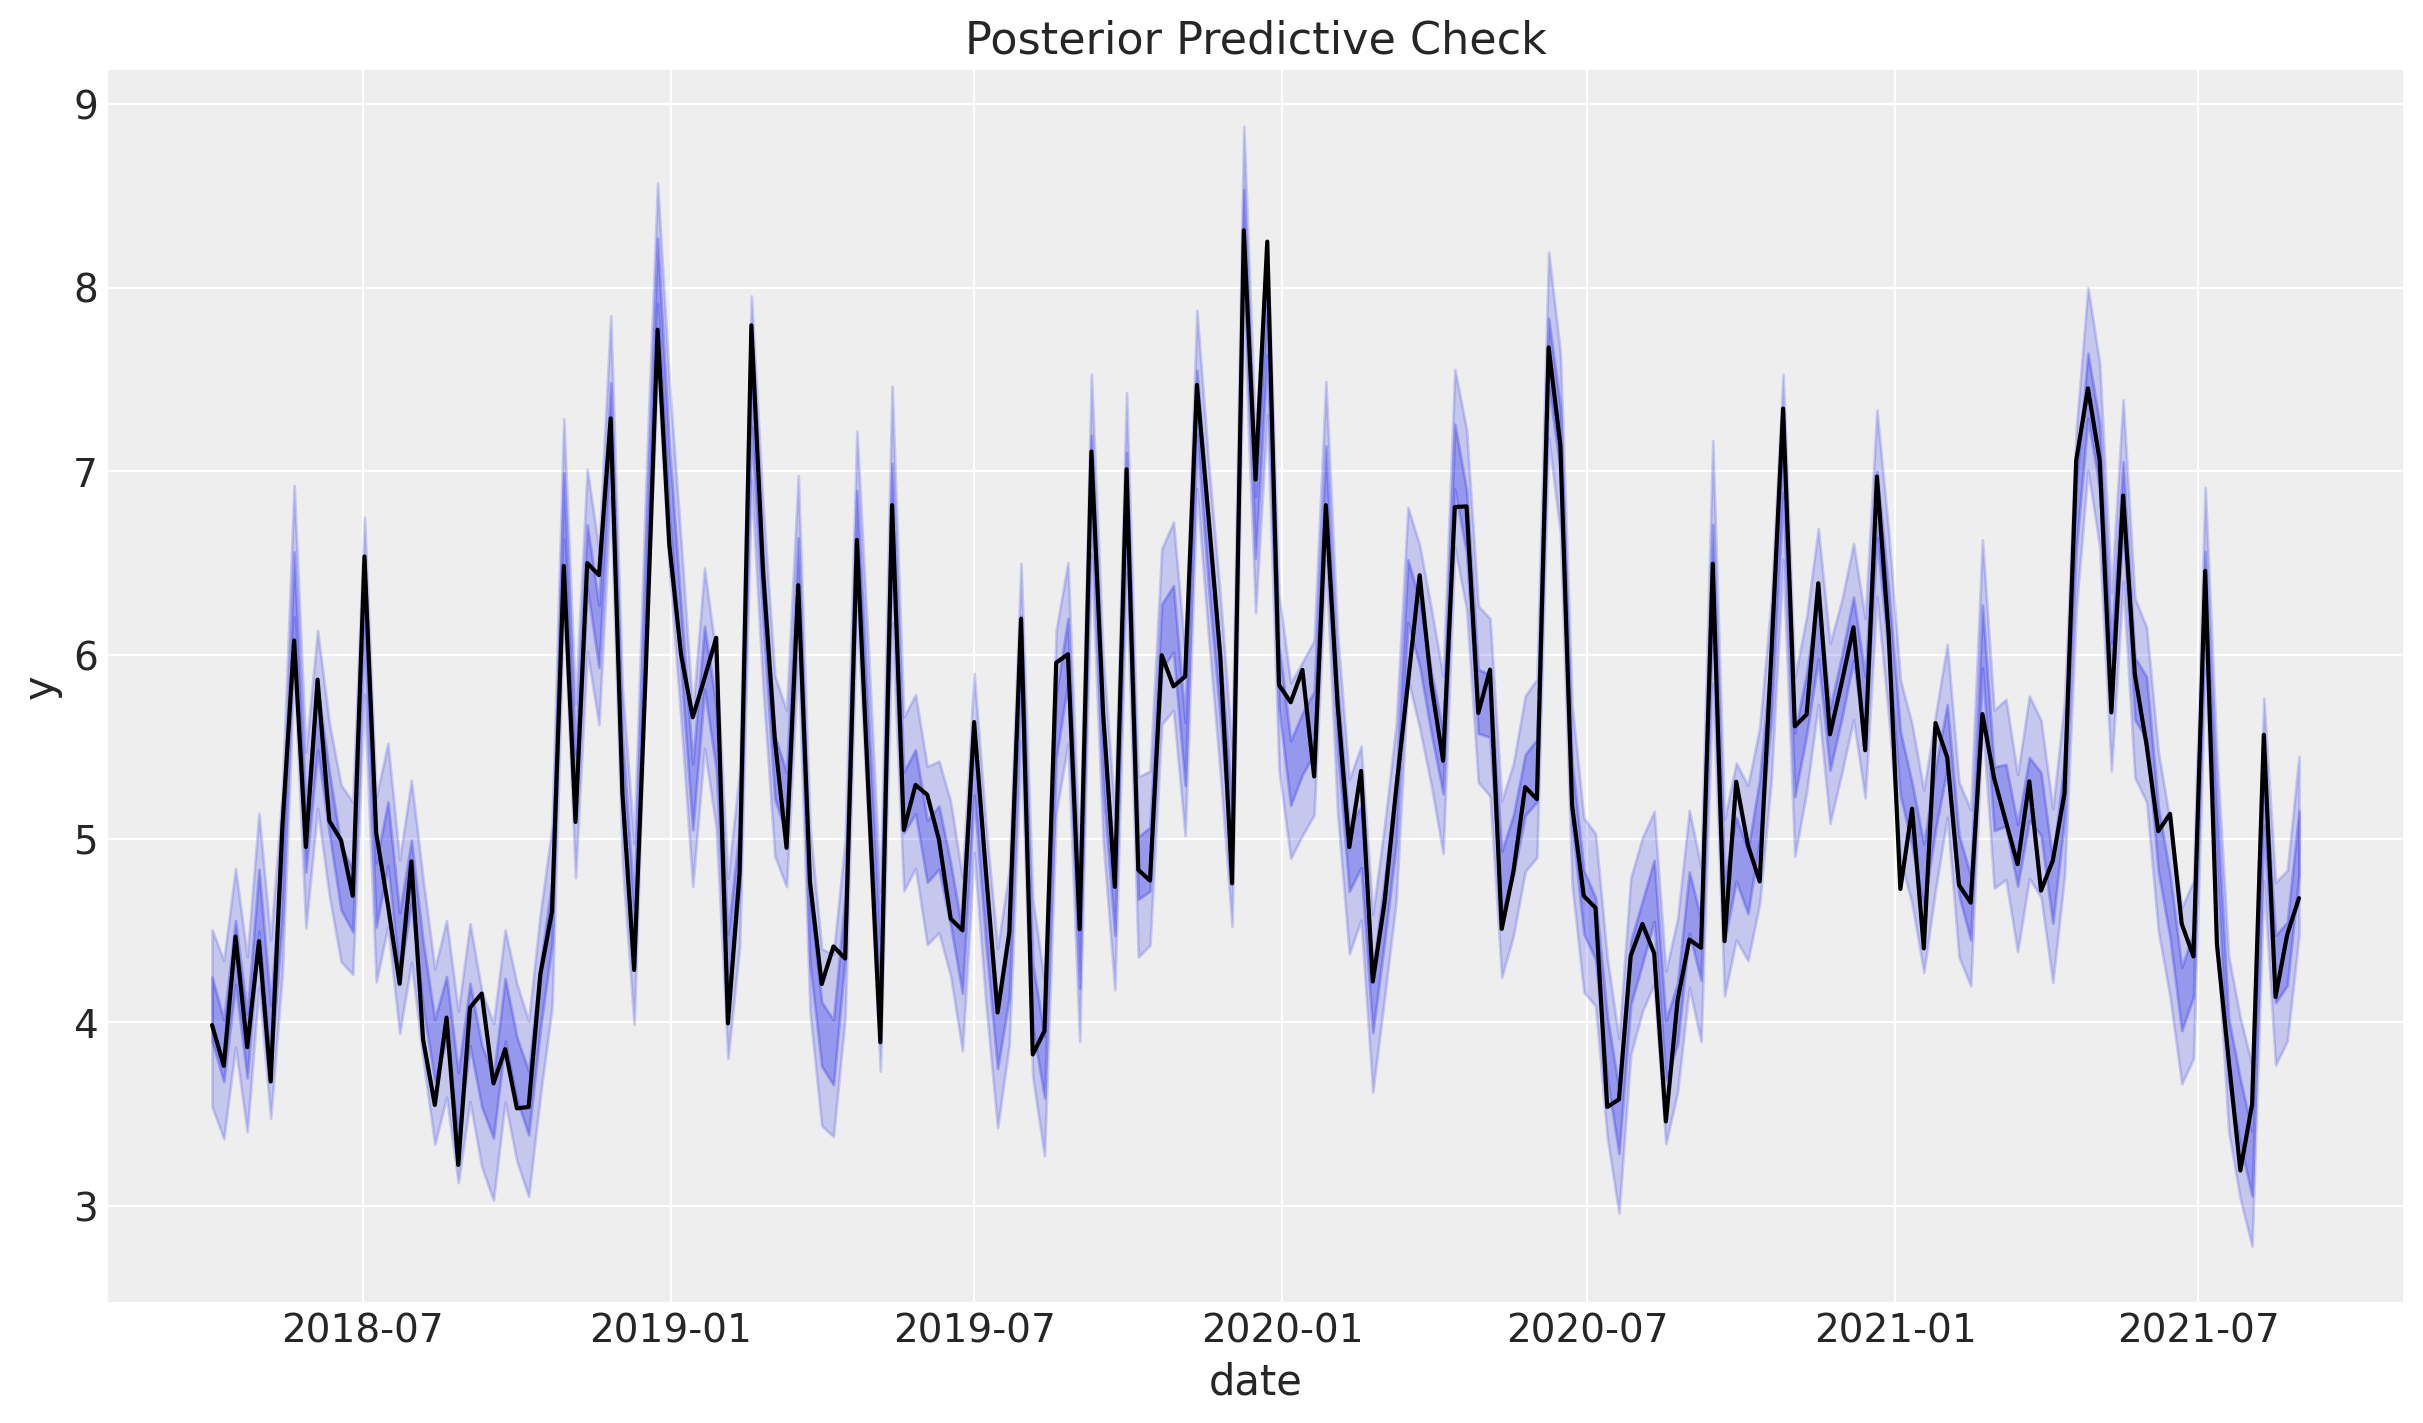

In [35]:
mmm.plot_posterior_predictive(original_scale=True);


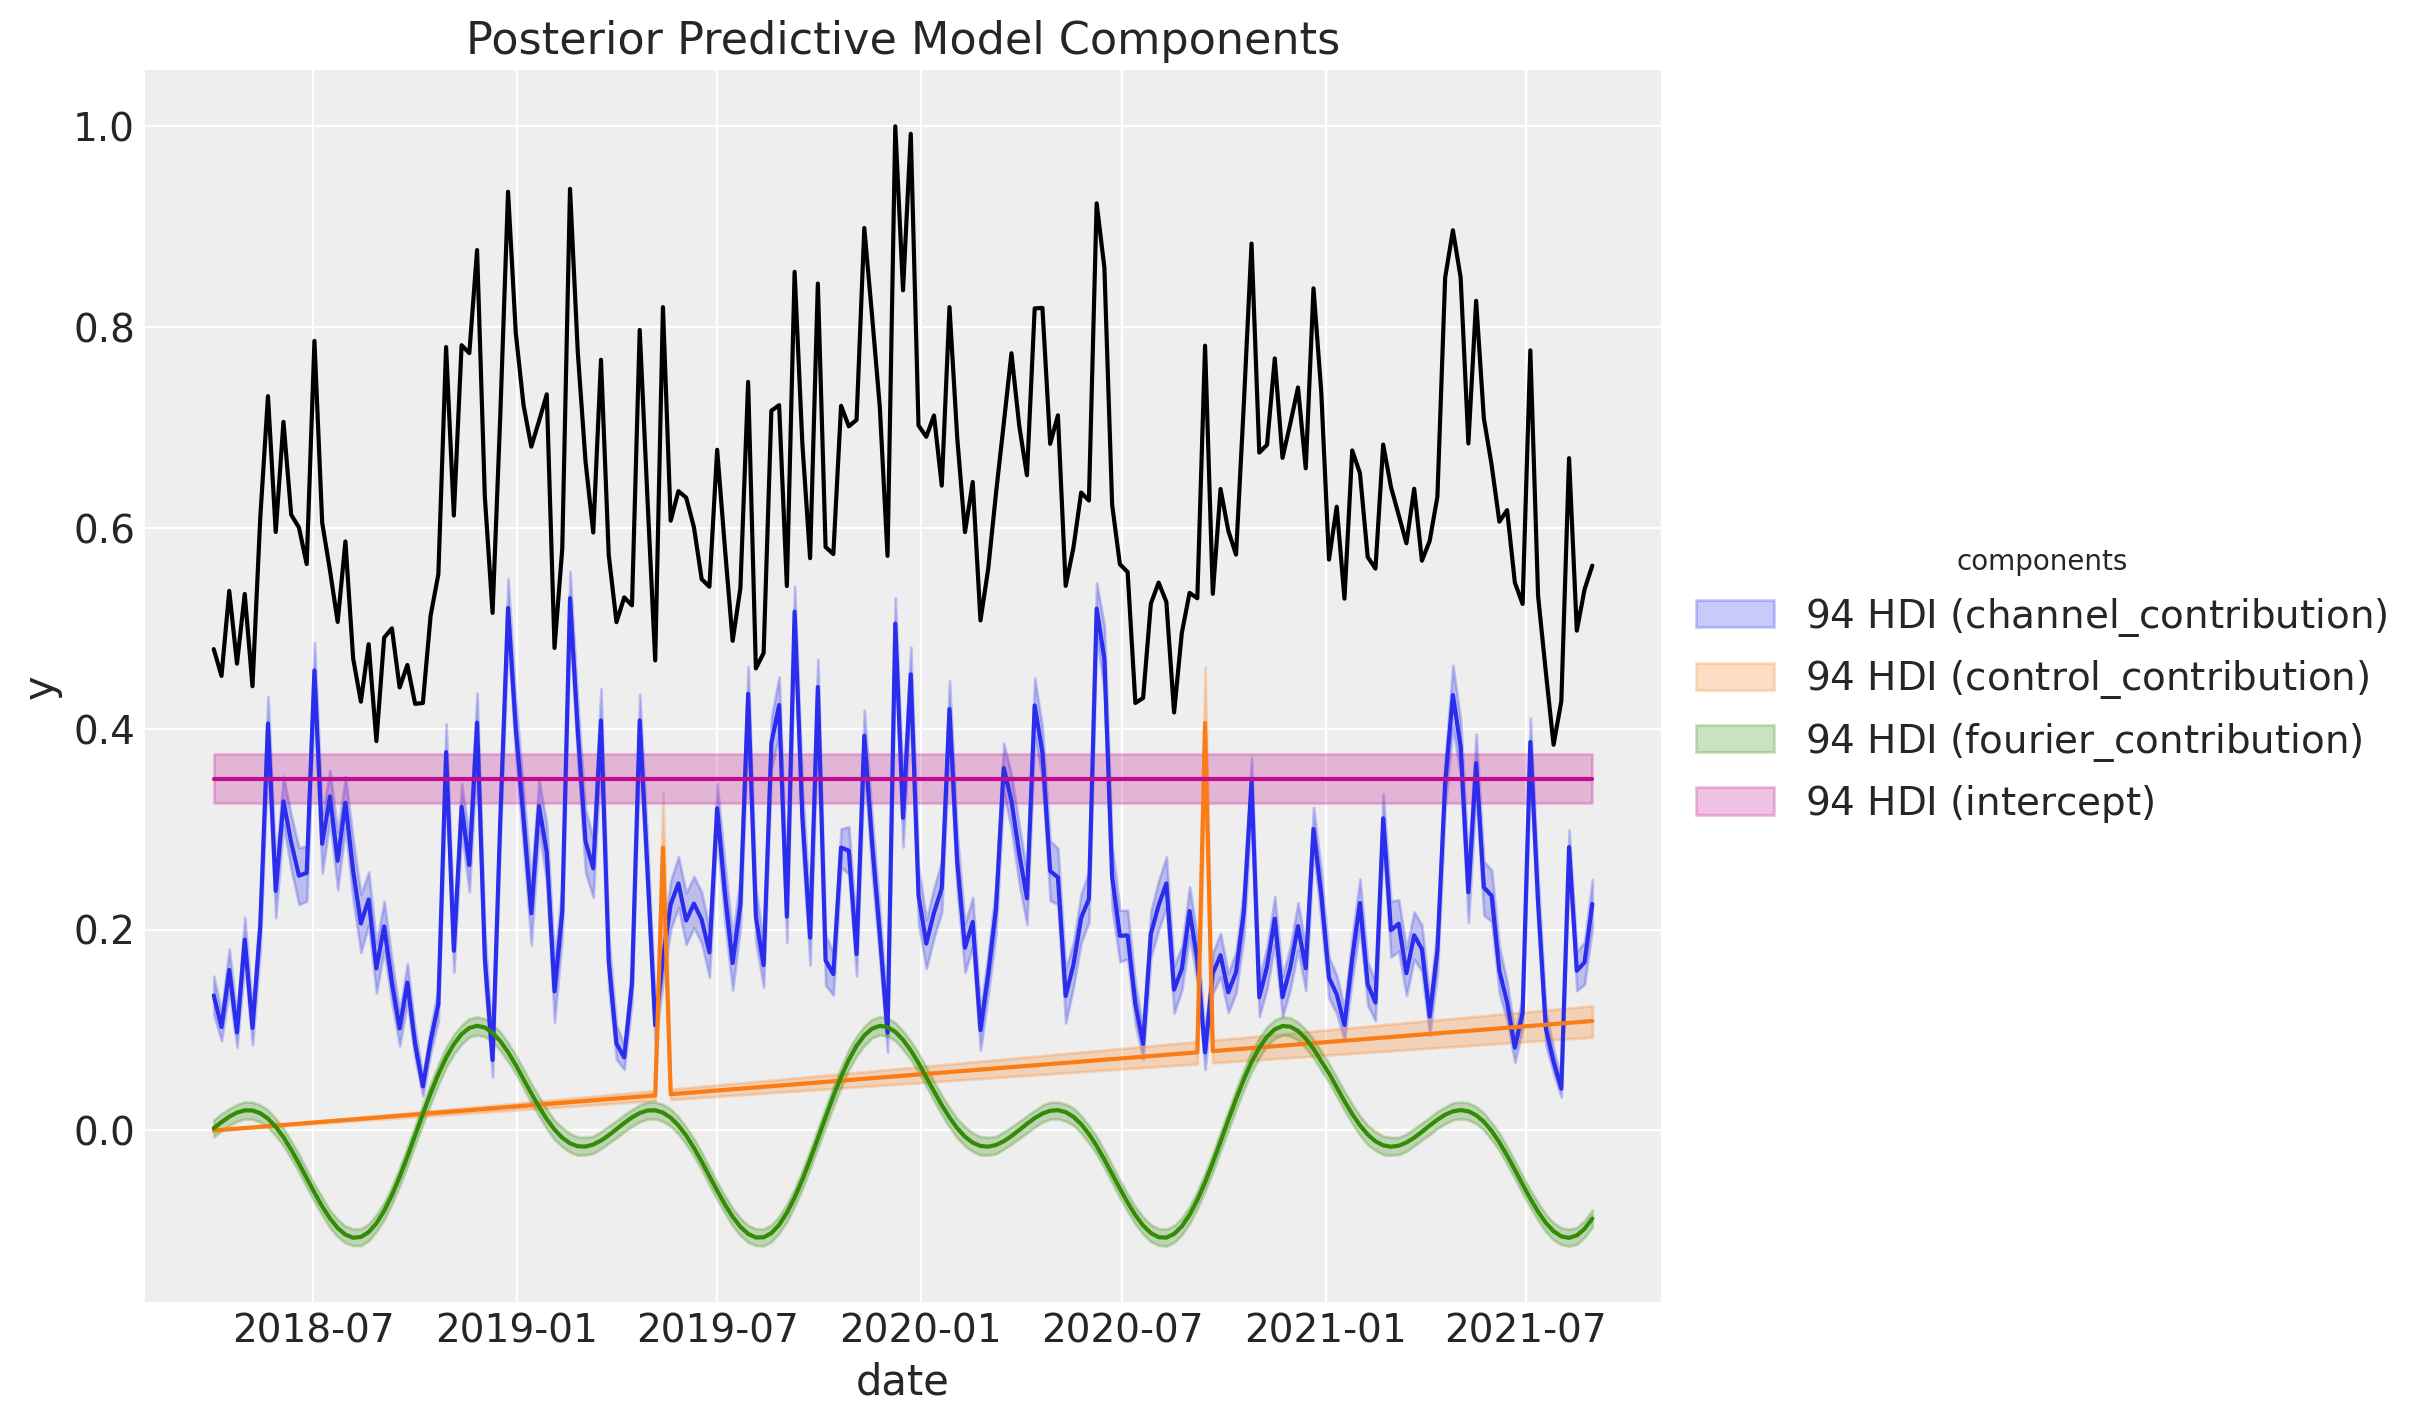

In [36]:
mmm.plot_components_contributions();


In [37]:
mmm.get_target_transformer()


Pipeline(steps=[('scaler', MaxAbsScaler())])

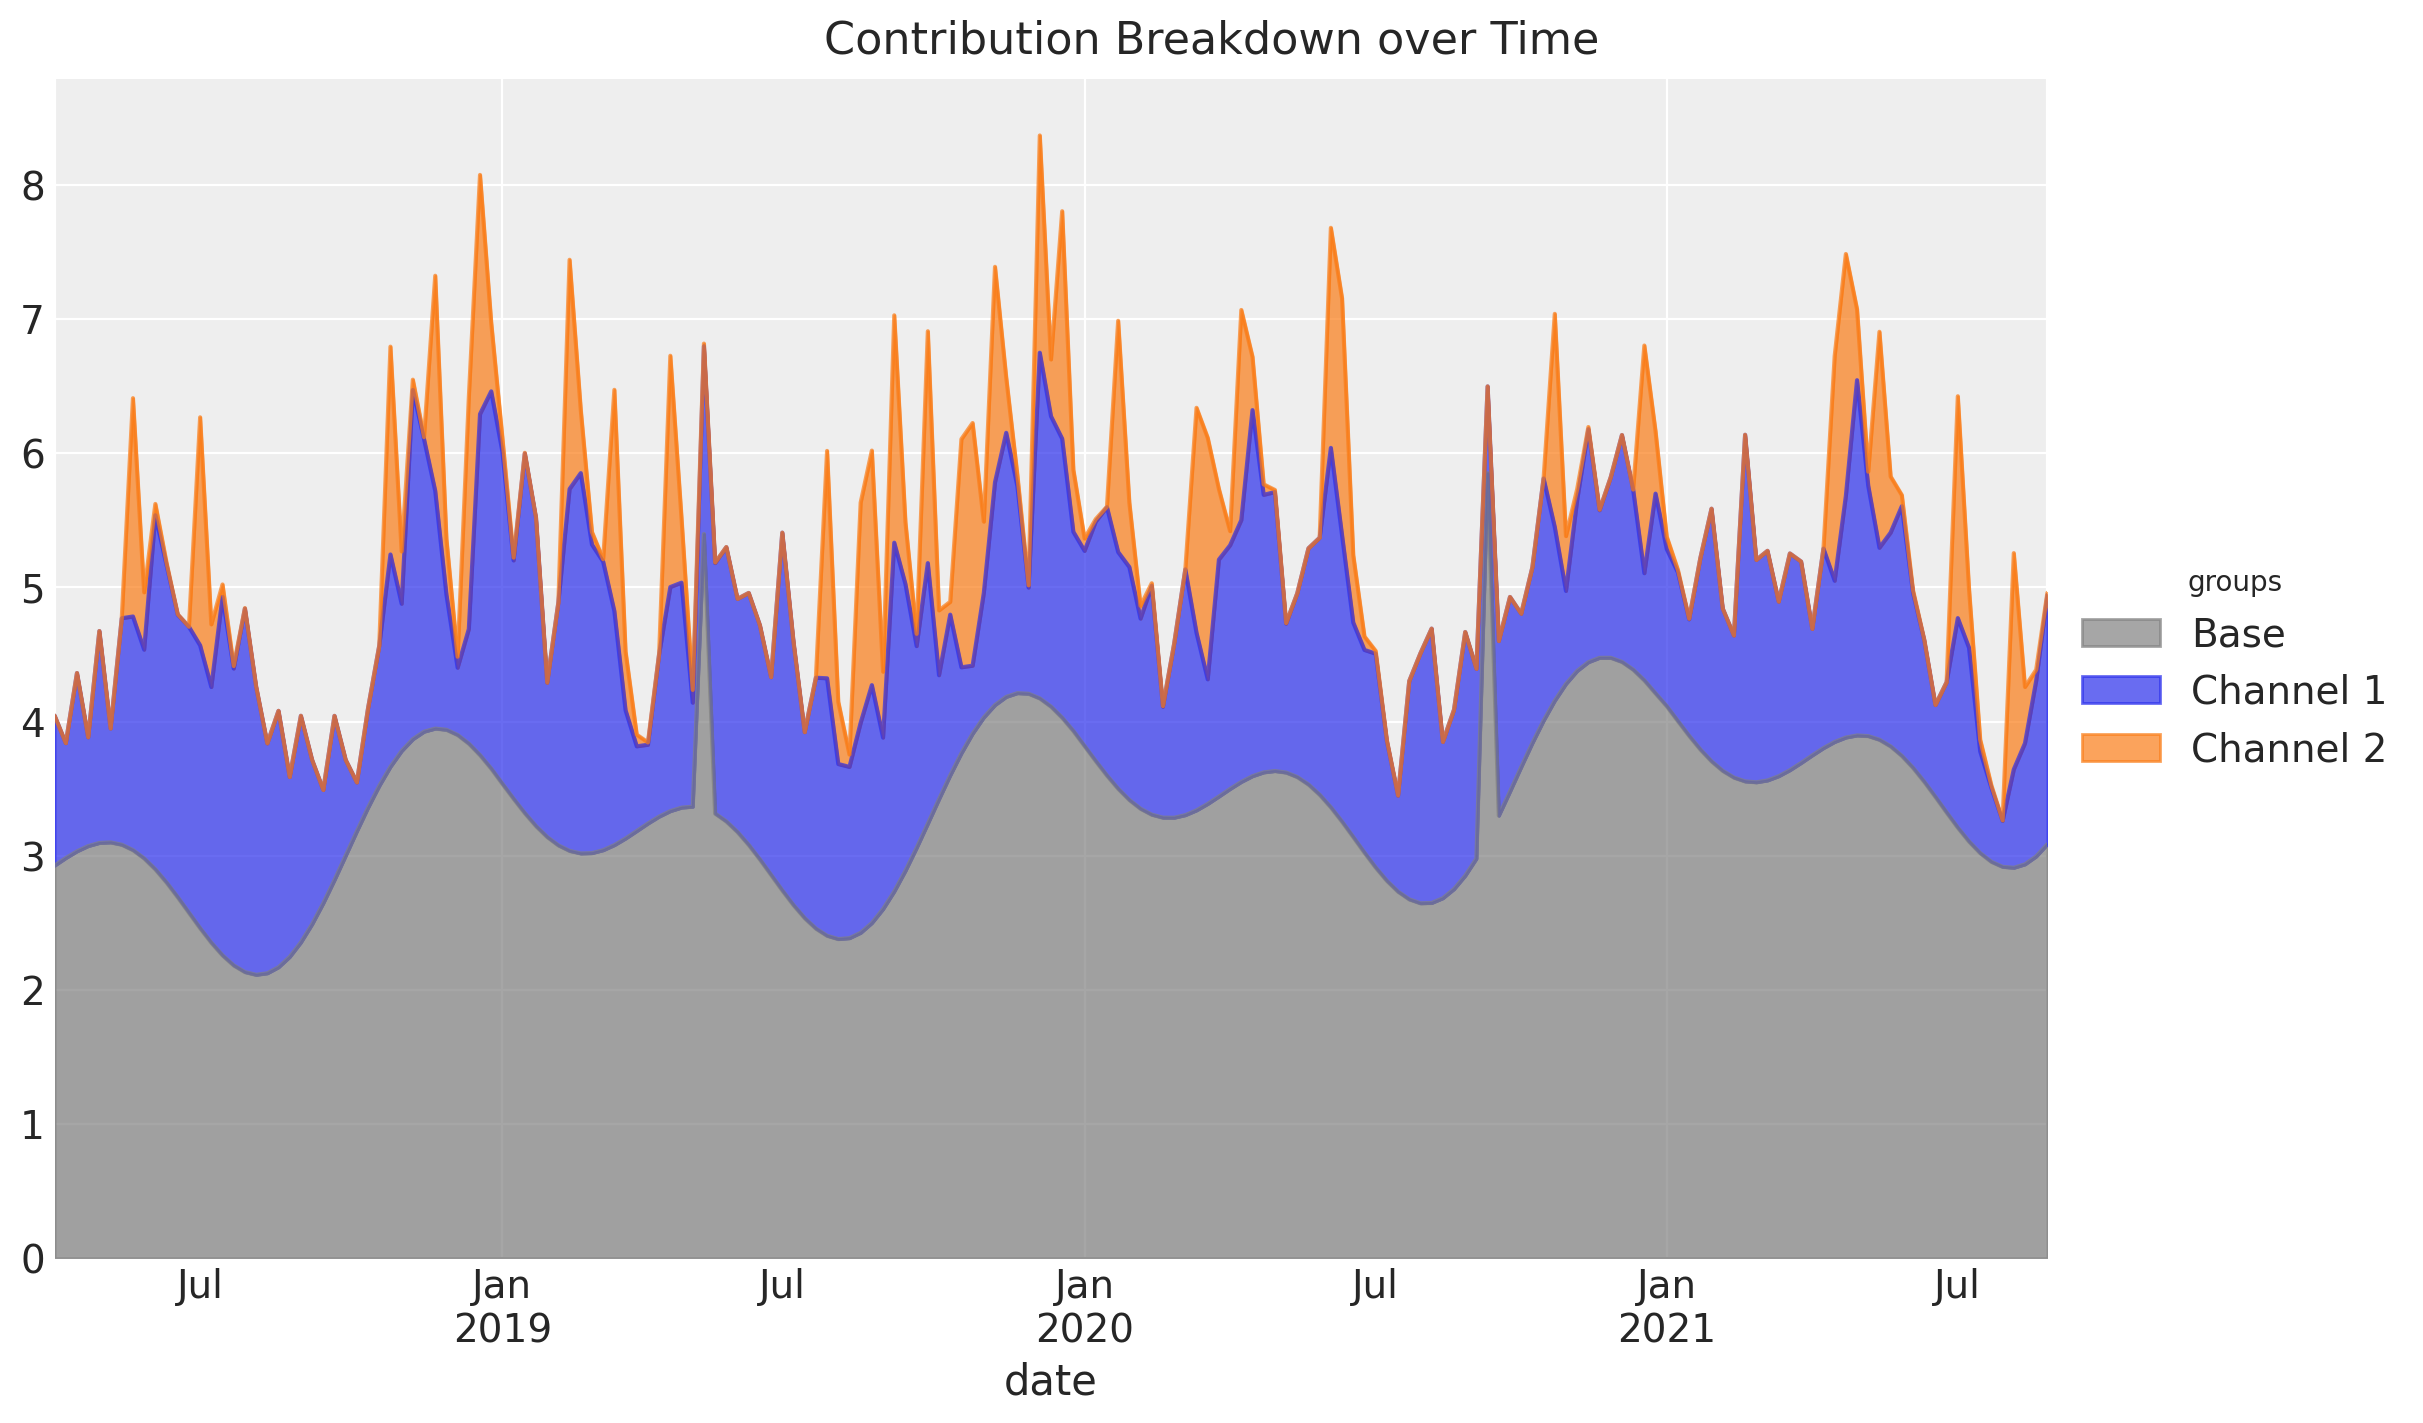

In [38]:
groups = {
    "Base": [
        "intercept",
        "event_1",
        "event_2",
        "t",
        "sin_order_1",
        "sin_order_2",
        "cos_order_1",
        "cos_order_2",
    ],
    "Channel 1": ["x1"],
    "Channel 2": ["x2"],
}

fig = mmm.plot_grouped_contribution_breakdown_over_time(
    stack_groups=groups,
    original_scale=True,
    area_kwargs={
        "color": {
            "Channel 1": "C0",
            "Channel 2": "C1",
            "Base": "gray",
            "Seasonality": "black",
        },
        "alpha": 0.7,
    },
)

fig.suptitle("Contribution Breakdown over Time", fontsize=16);


In [39]:
get_mean_contributions_over_time_df = mmm.compute_mean_contributions_over_time(
    original_scale=True
)

get_mean_contributions_over_time_df.head()


x1   x2  event_1  event_2         t  sin_order_1  \
date                                                                 
2018-04-02  1.118203  0.0      0.0      0.0  0.000000     0.027973   
2018-04-09  0.856558  0.0      0.0      0.0  0.005091     0.027731   
2018-04-16  1.329337  0.0      0.0      0.0  0.010181     0.027087   
2018-04-23  0.810994  0.0      0.0      0.0  0.015272     0.026051   
2018-04-30  1.579719  0.0      0.0      0.0  0.020362     0.024637   

            cos_order_1  sin_order_2  cos_order_2  intercept  
date                                                          
2018-04-02    -0.006191     0.011284    -0.014962    2.90828  
2018-04-09    -0.069025     0.124716    -0.014445    2.90828  
2018-04-16    -0.130859     0.230950    -0.013095    2.90828  
2018-04-23    -0.190798     0.323853    -0.010989    2.90828  
2018-04-30    -0.247973     0.398063    -0.008249    2.90828

### 5. Media Parameters

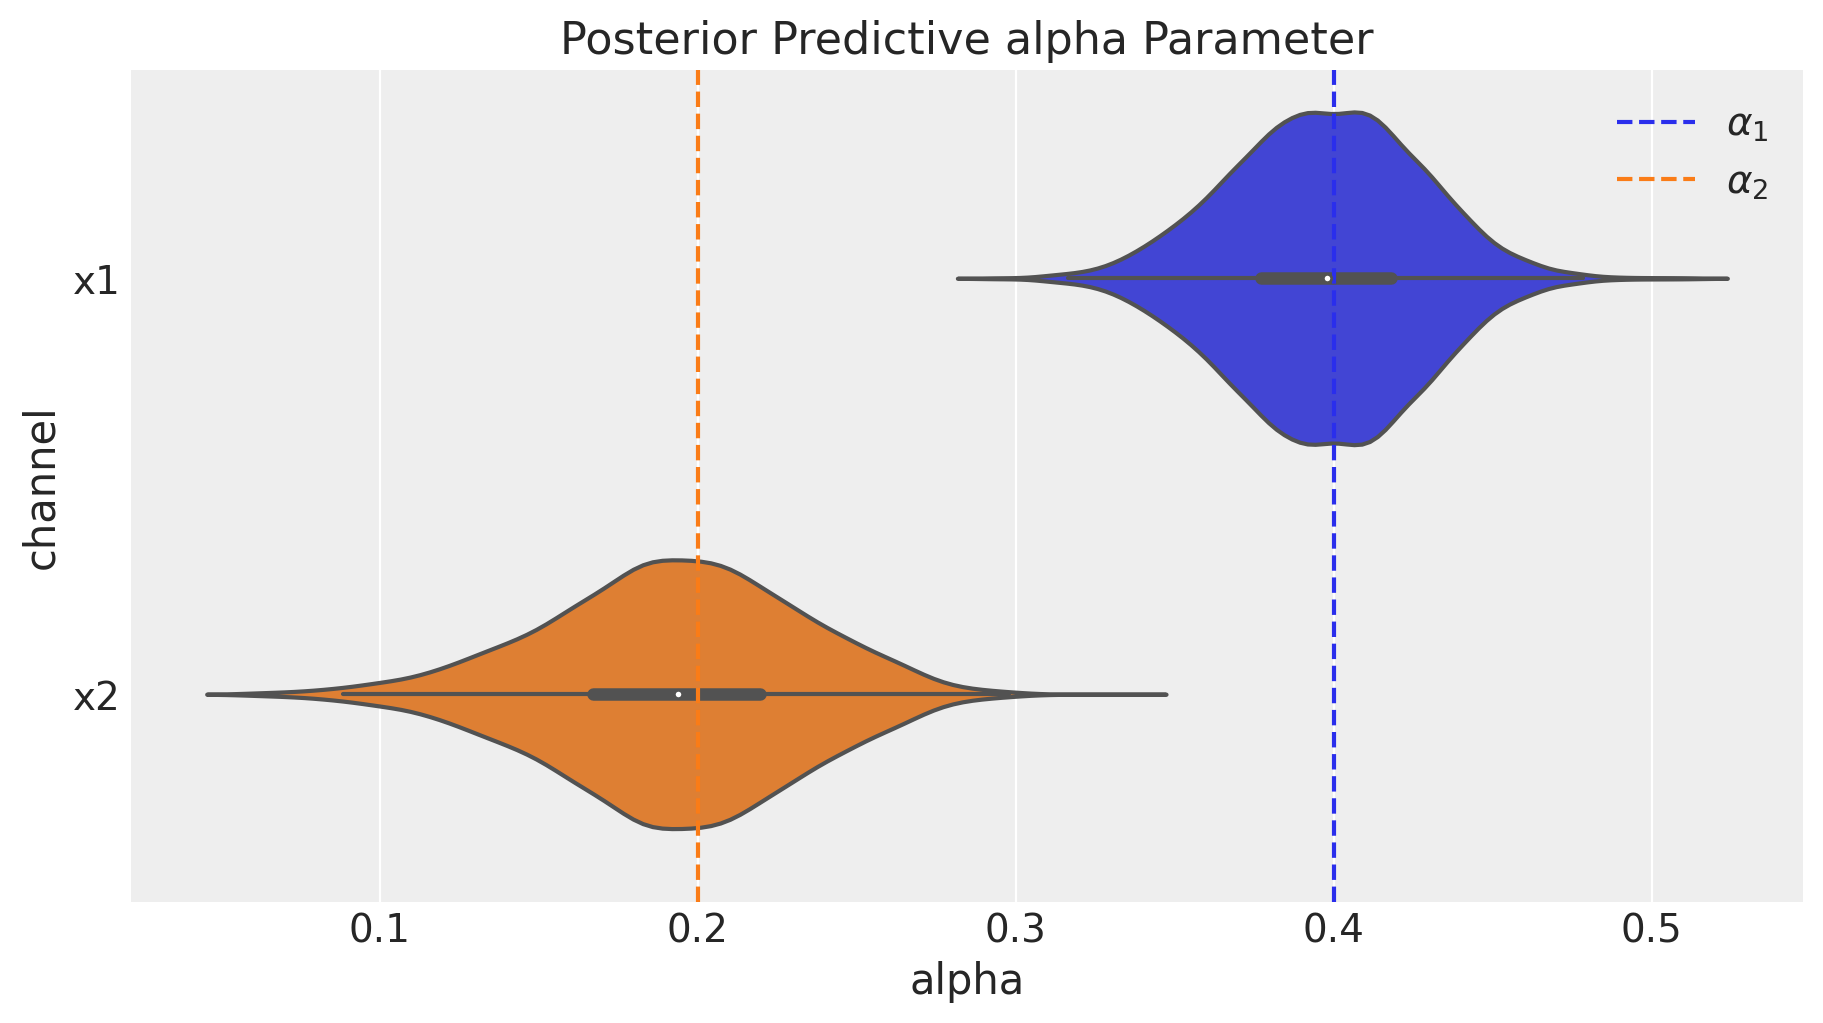

In [40]:
fig = mmm.plot_channel_parameter(param_name="alpha", figsize=(9, 5))
ax = fig.axes[0]
ax.axvline(x=alpha1, color="C0", linestyle="--", label=r"$\alpha_1$")
ax.axvline(x=alpha2, color="C1", linestyle="--", label=r"$\alpha_2$")
ax.legend(loc="upper right");


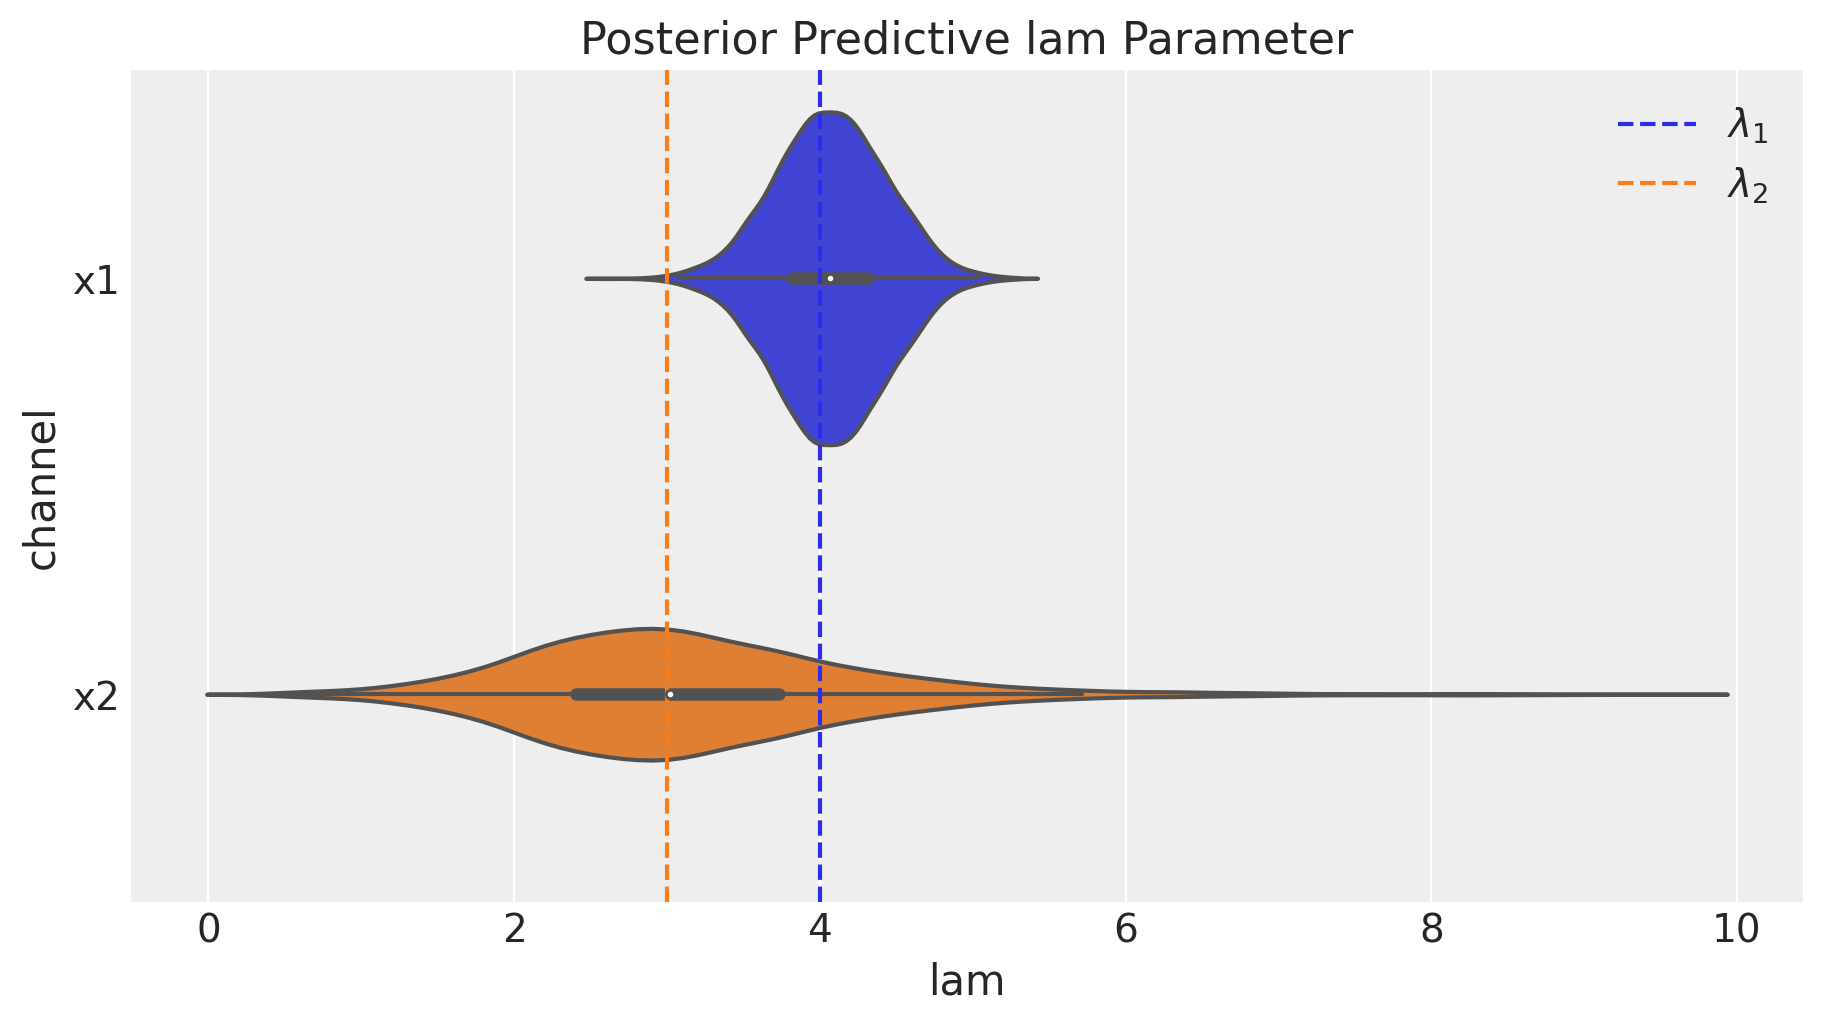

In [41]:
fig = mmm.plot_channel_parameter(param_name="lam", figsize=(9, 5))
ax = fig.axes[0]
ax.axvline(x=lam1, color="C0", linestyle="--", label=r"$\lambda_1$")
ax.axvline(x=lam2, color="C1", linestyle="--", label=r"$\lambda_2$")
ax.legend(loc="upper right");


### 6. Media Deep-Dive

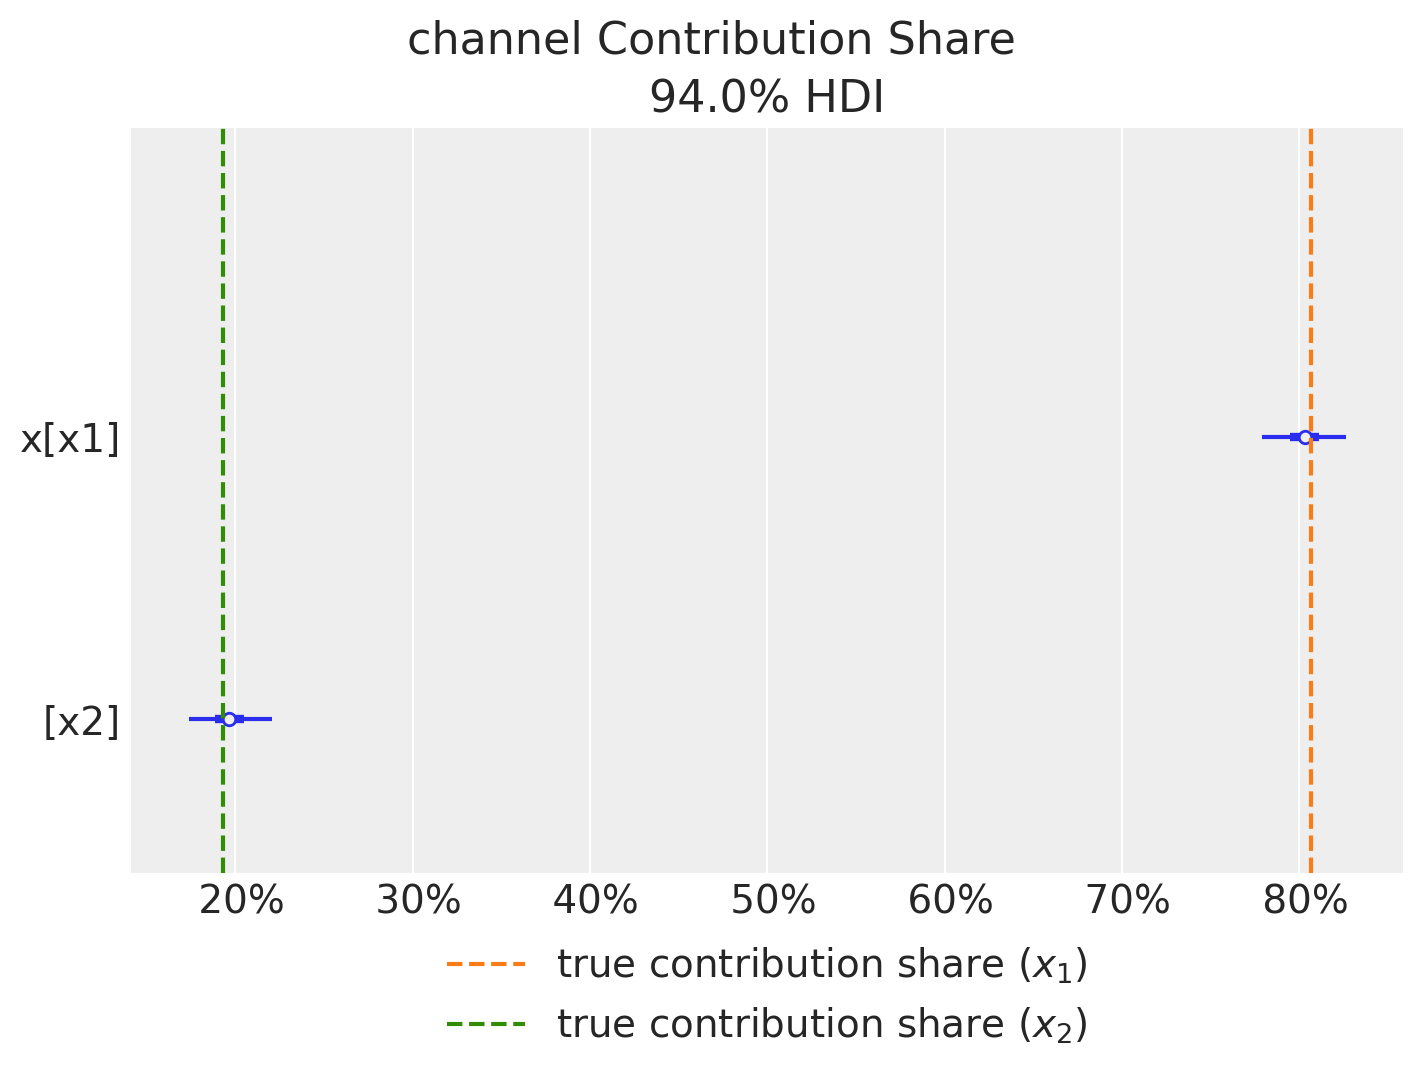

In [42]:
fig = mmm.plot_channel_contribution_share_hdi(figsize=(7, 5))
ax = fig.axes[0]
ax.axvline(
    x=contribution_share_x1,
    color="C1",
    linestyle="--",
    label="true contribution share ($x_1$)",
)
ax.axvline(
    x=contribution_share_x2,
    color="C2",
    linestyle="--",
    label="true contribution share ($x_2$)",
)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=1);


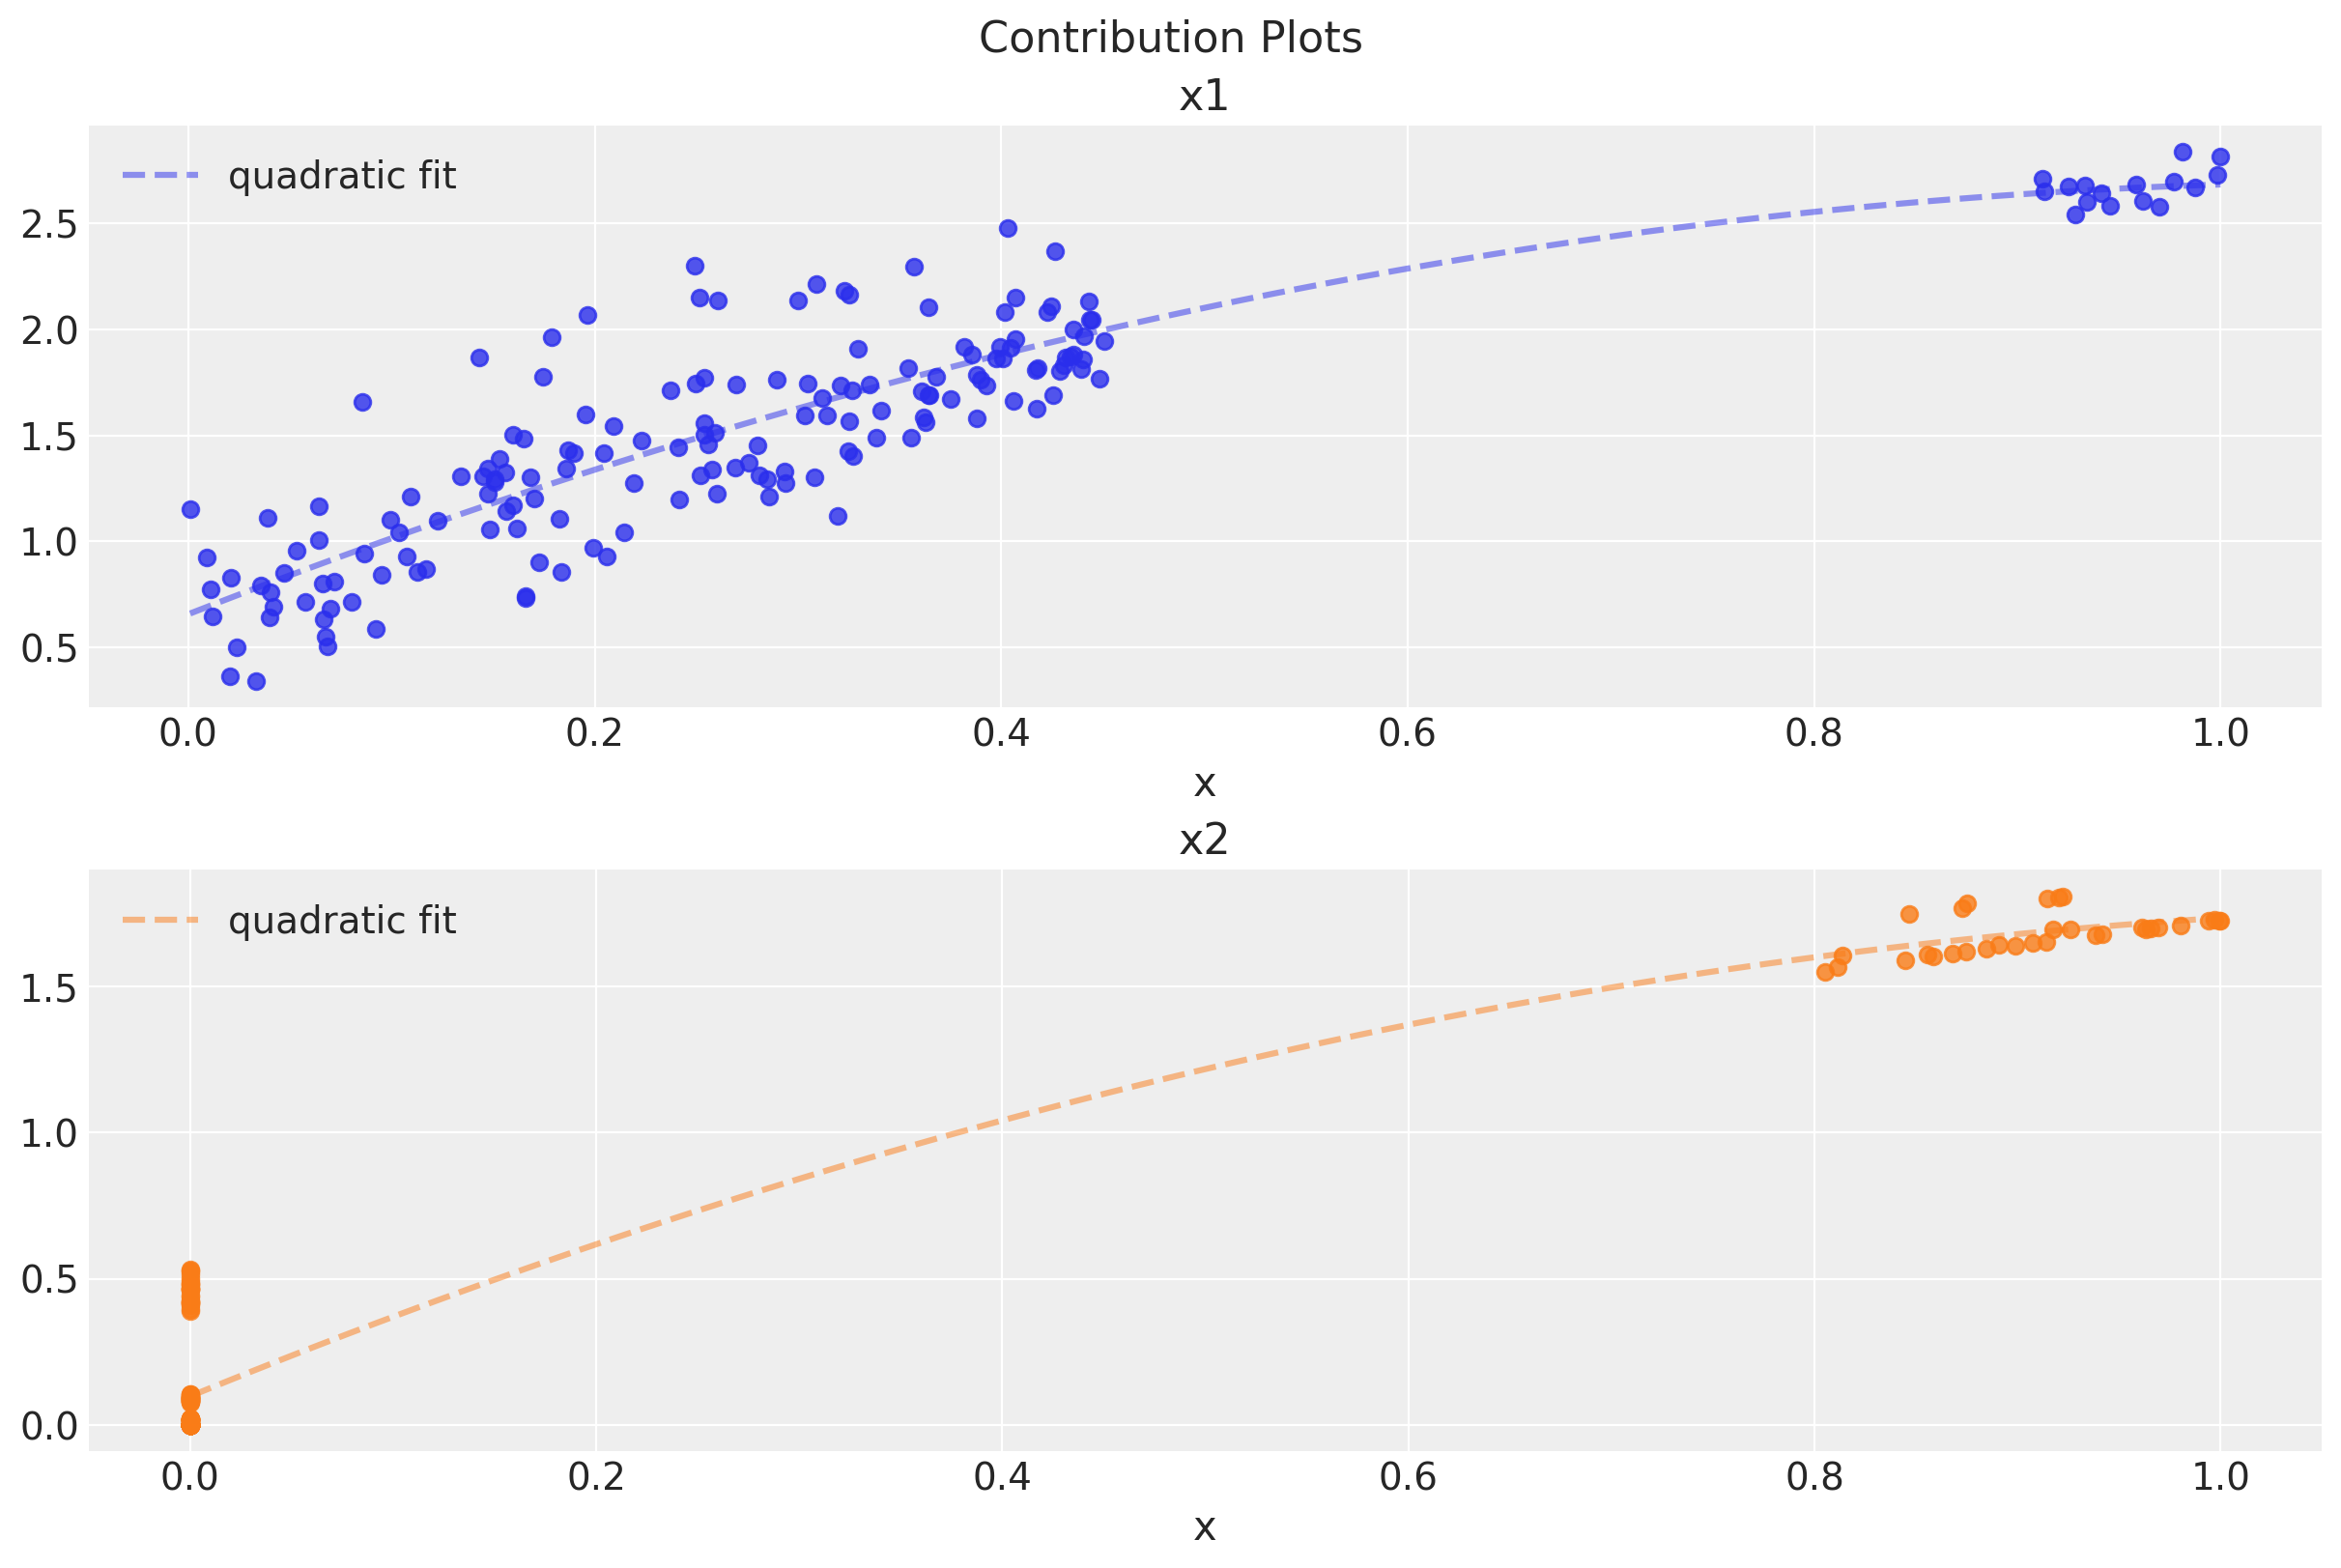

In [43]:
fig = mmm.plot_direct_contribution_curves()
[ax.set(xlabel="x") for ax in fig.axes];


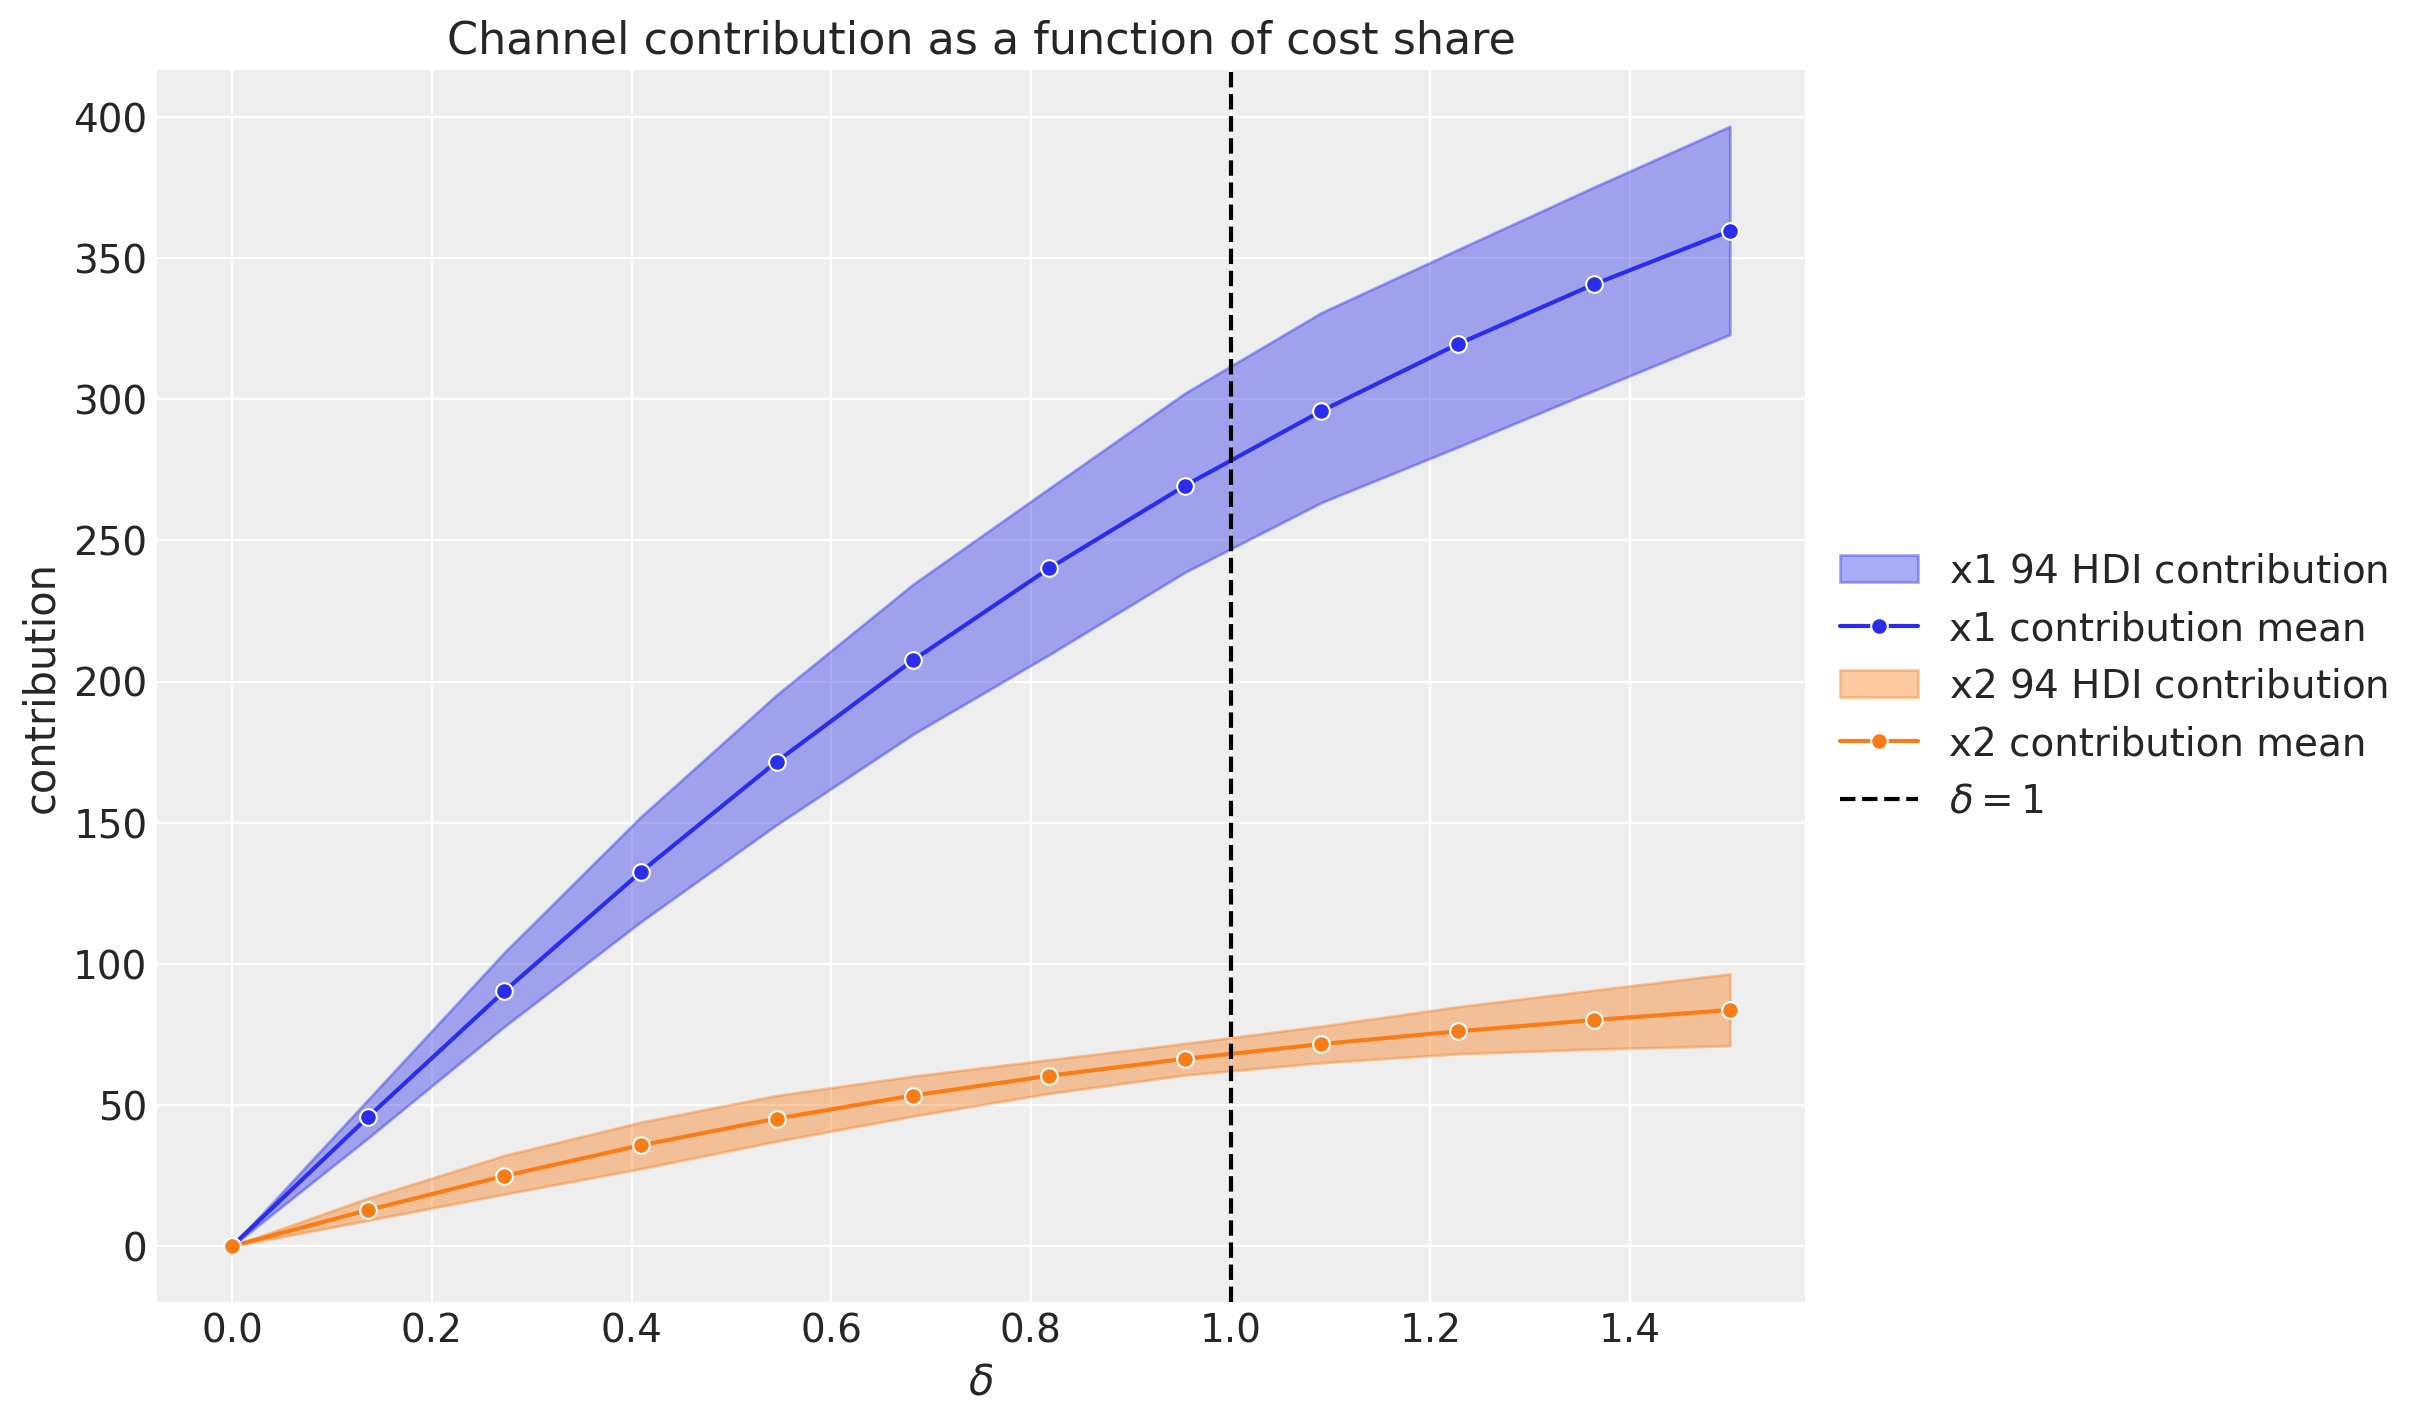

In [44]:
mmm.plot_channel_contributions_grid(start=0, stop=1.5, num=12);


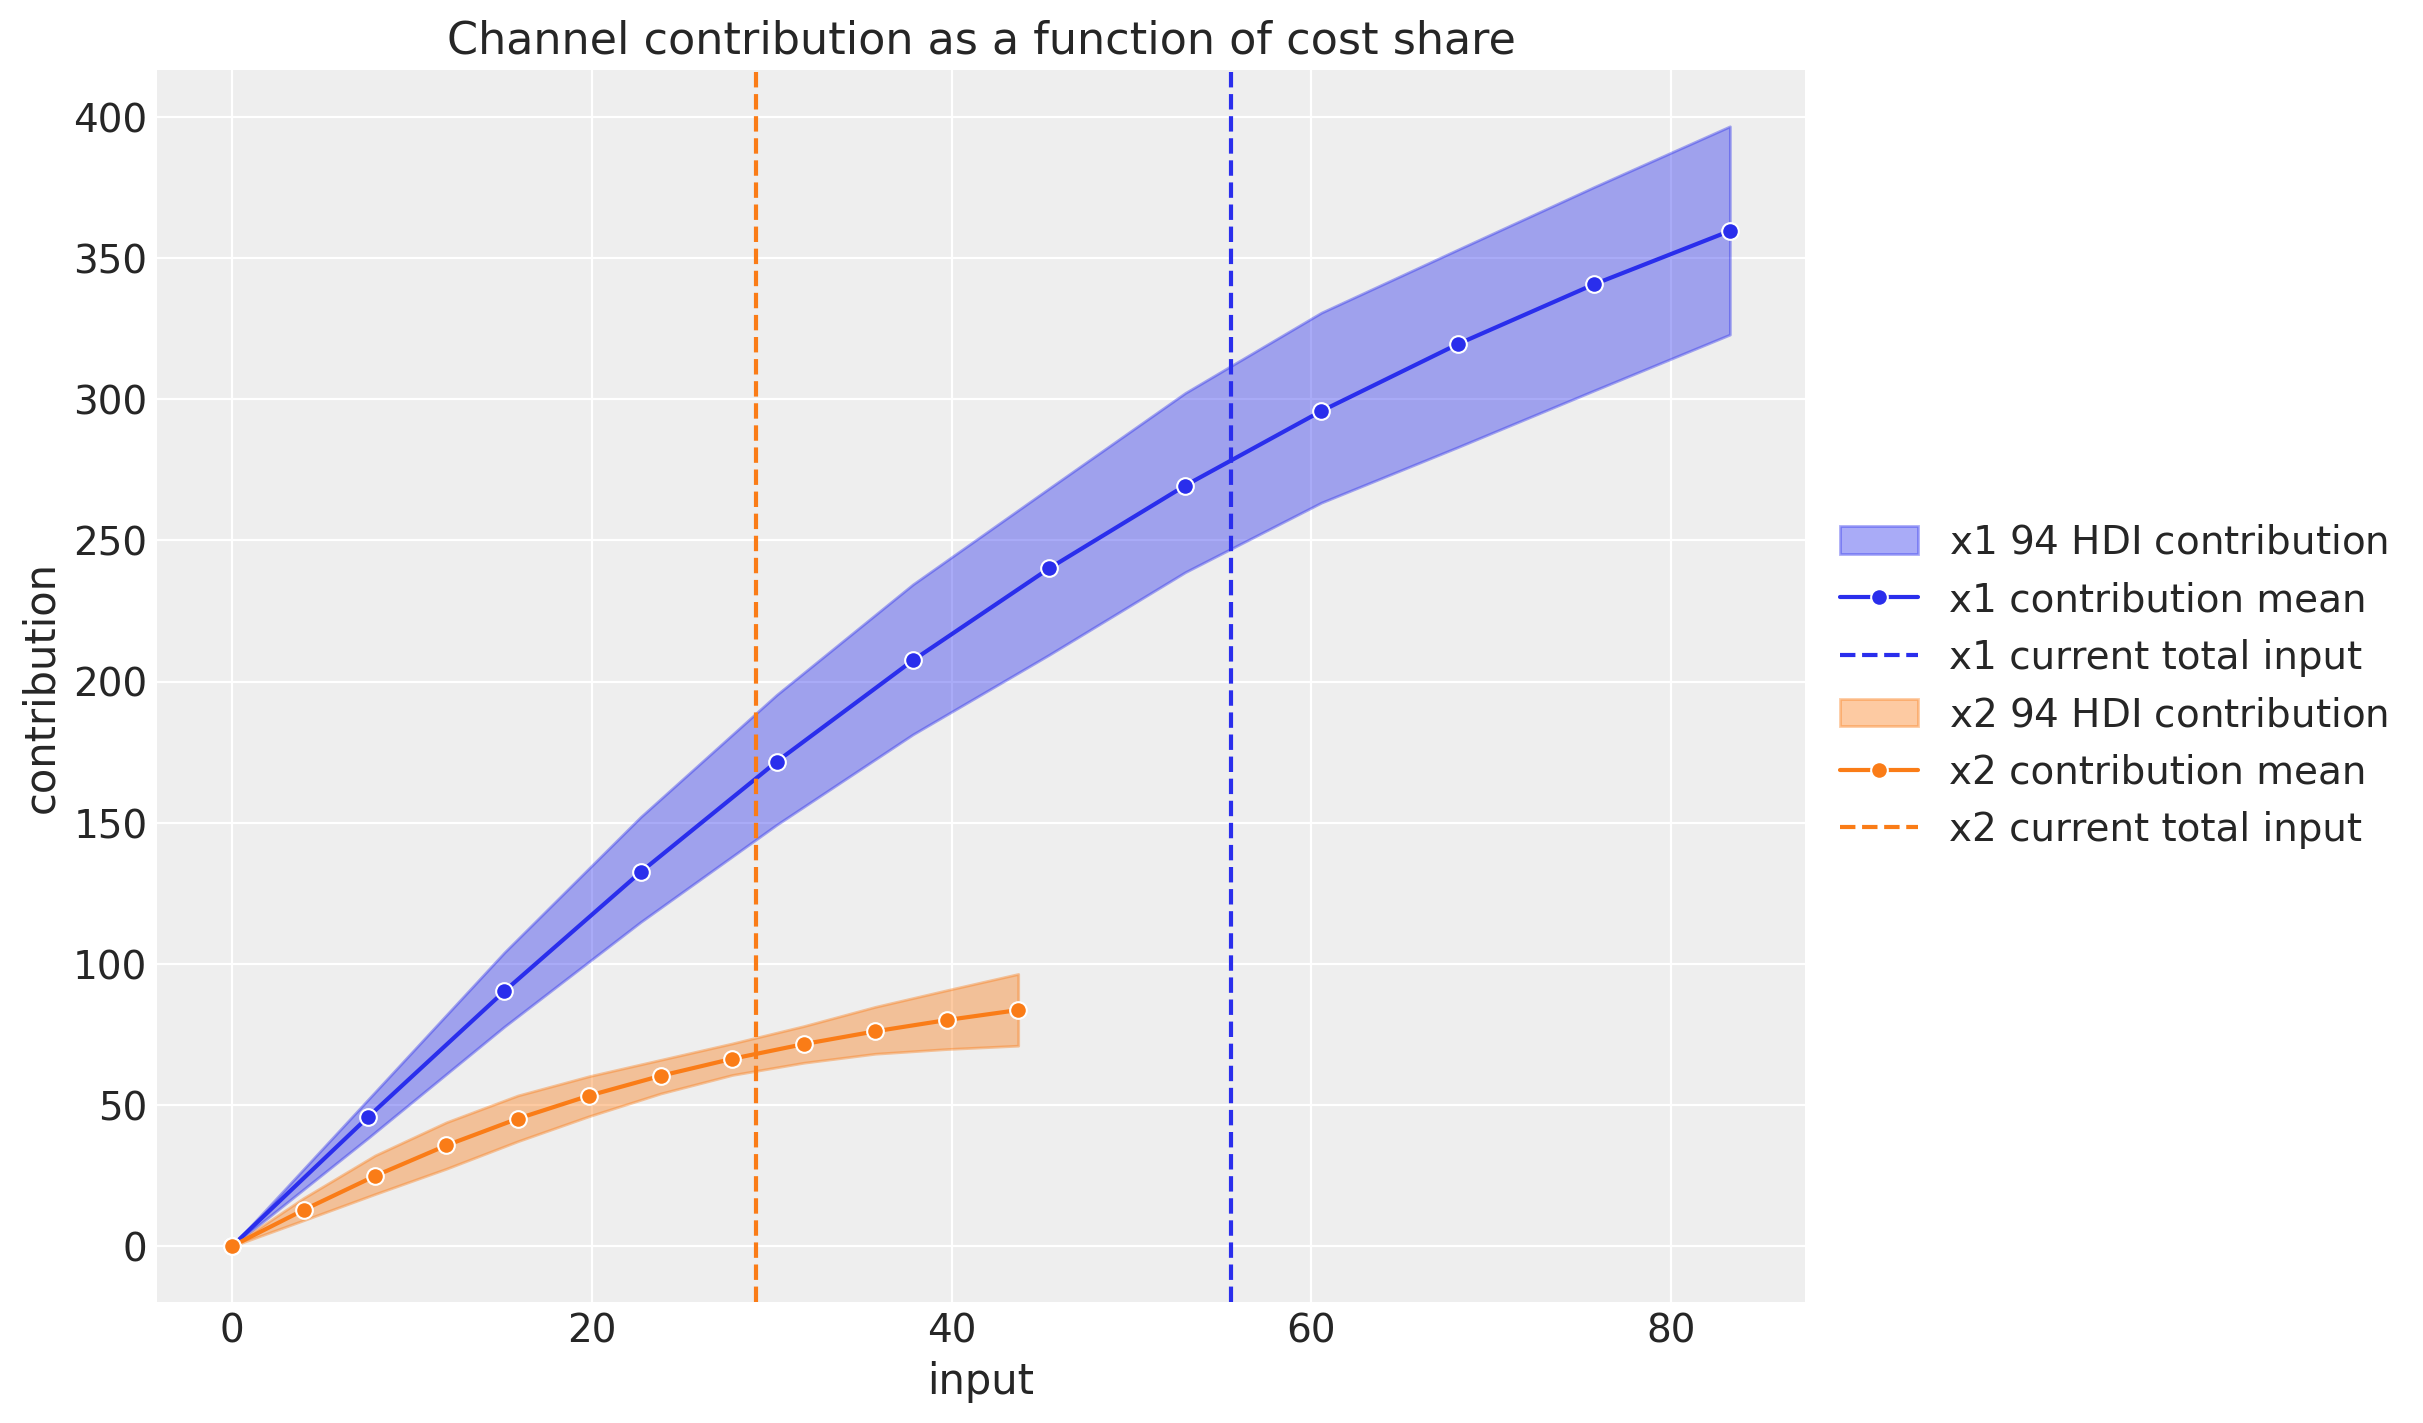

In [45]:
mmm.plot_channel_contributions_grid(start=0, stop=1.5, num=12, absolute_xrange=True);


### 7. Contribution Recovery

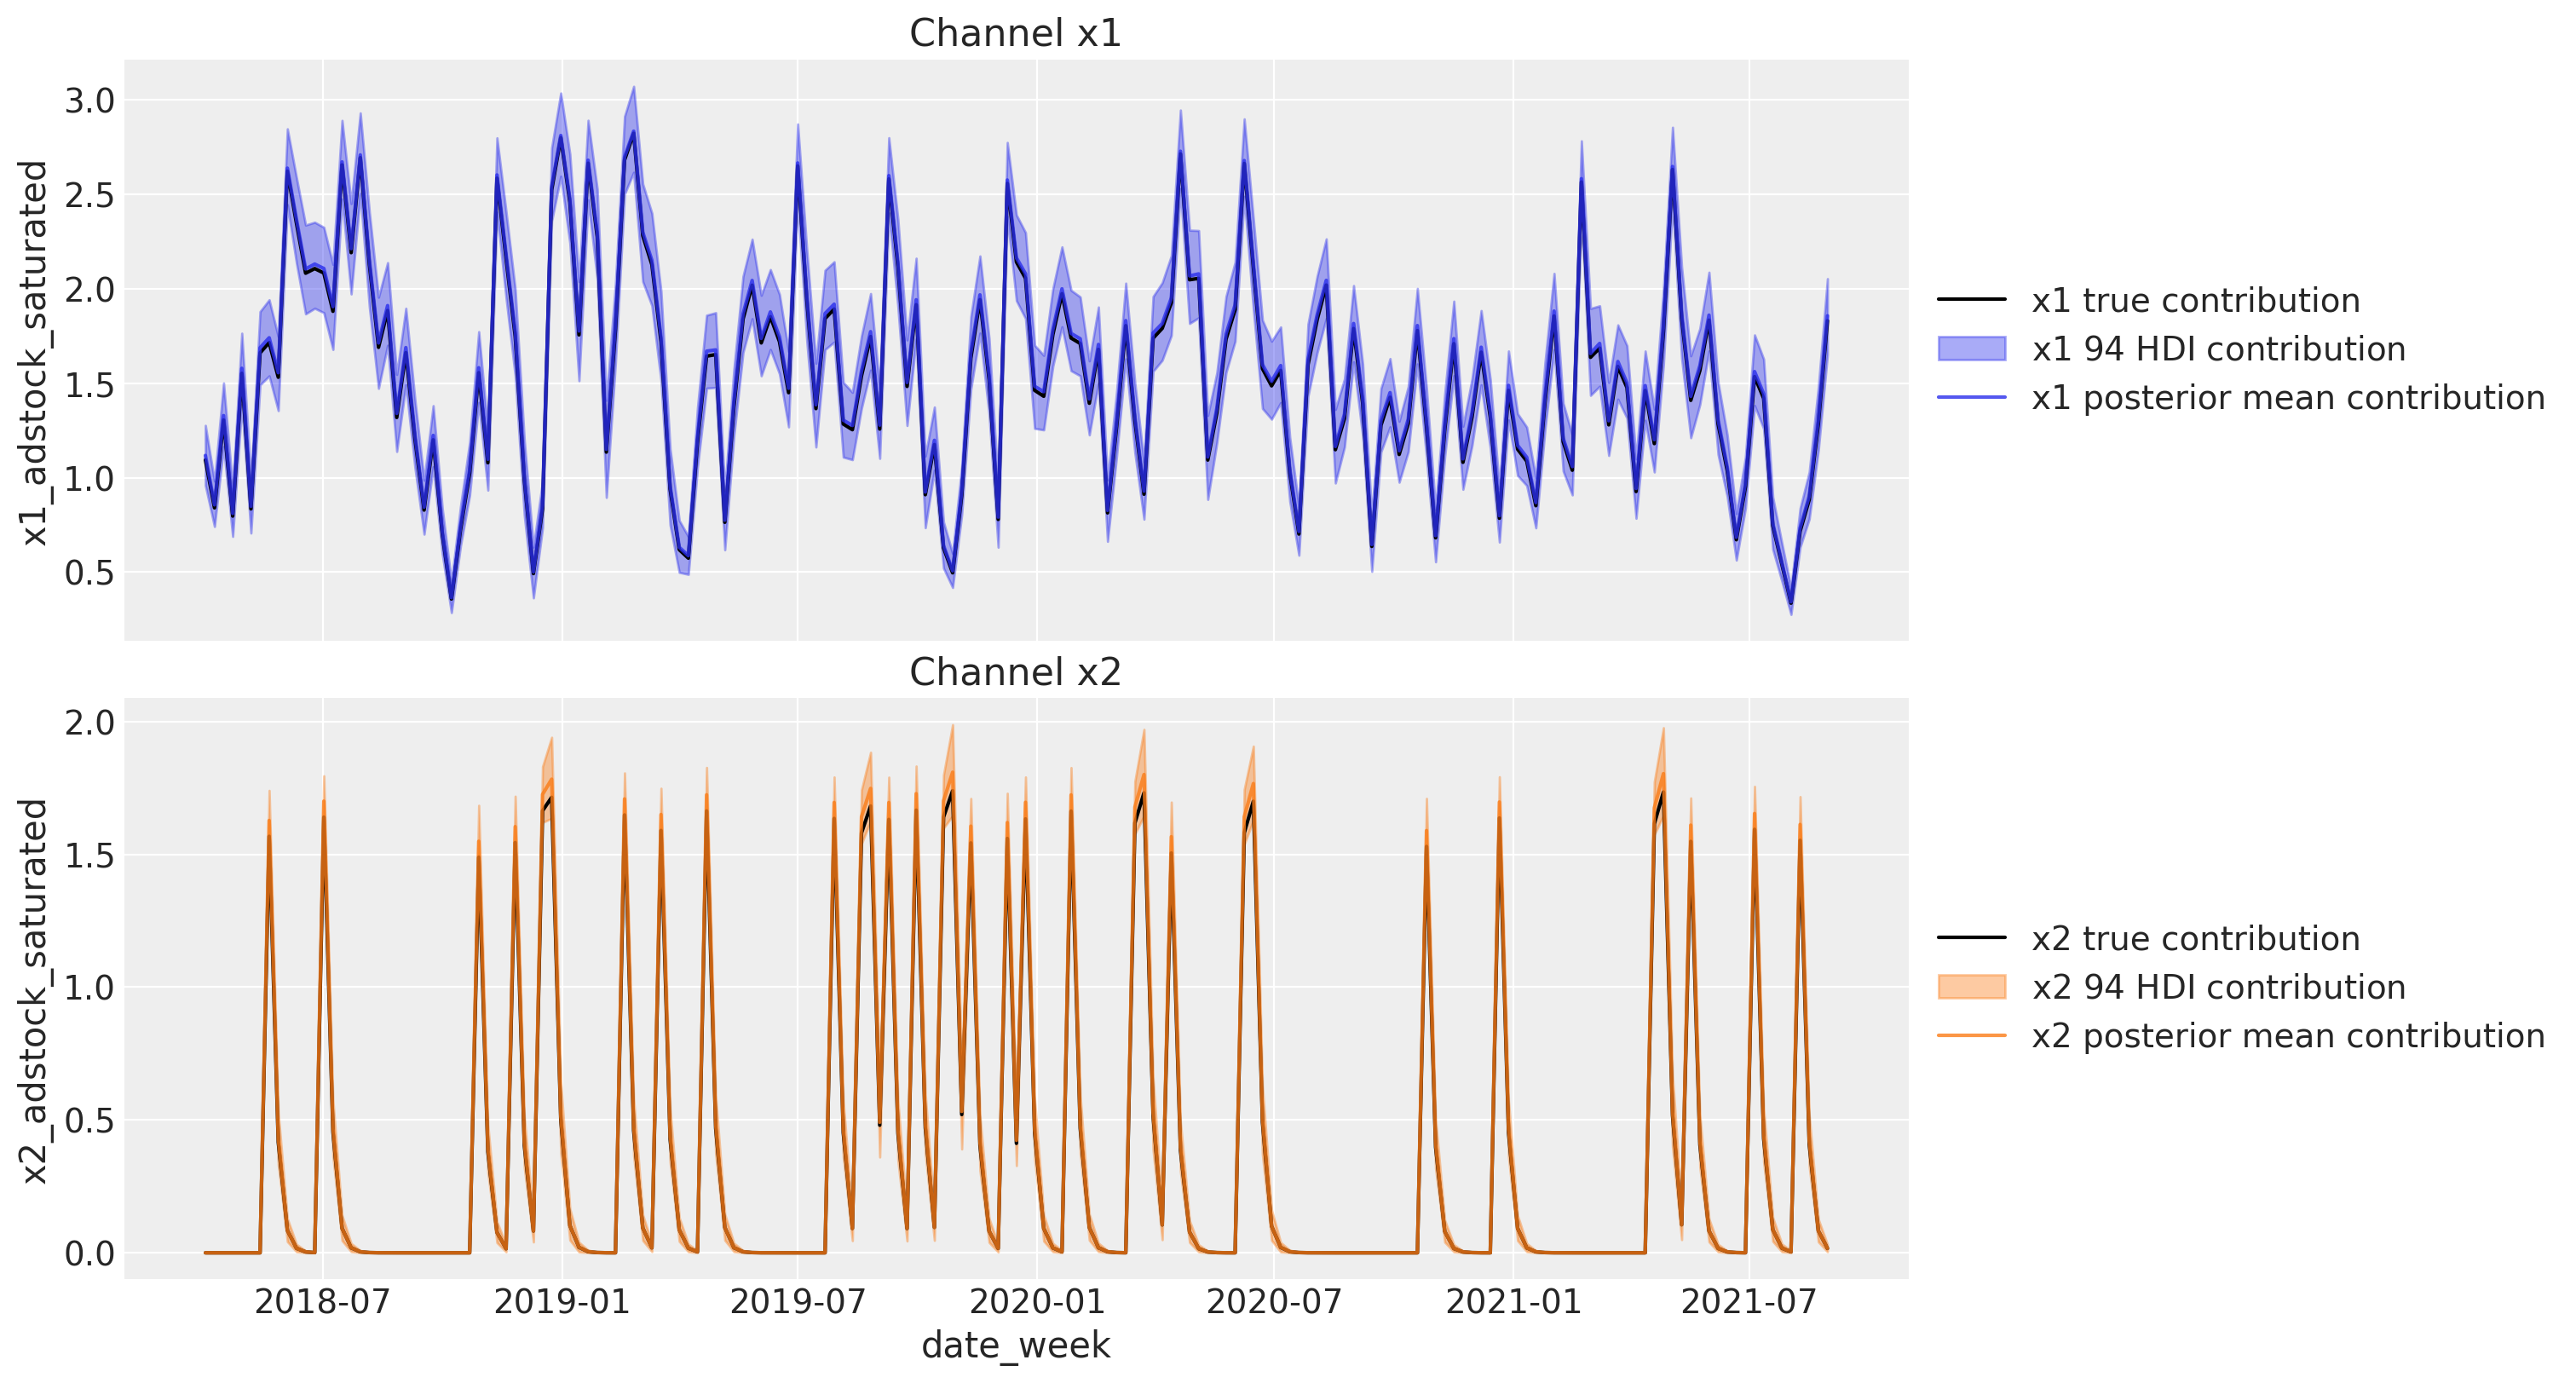

In [46]:
channels_contribution_original_scale = mmm.compute_channel_contribution_original_scale()
channels_contribution_original_scale_hdi = az.hdi(
    ary=channels_contribution_original_scale
)

fig, ax = plt.subplots(
    nrows=2, figsize=(15, 8), ncols=1, sharex=True, sharey=False, layout="constrained"
)

for i, x in enumerate(["x1", "x2"]):
    # Estimate true contribution in the original scale from the data generating process
    sns.lineplot(
        x=df["date_week"],
        y=amplitude * betas[i] * df[f"{x}_adstock_saturated"],
        color="black",
        label=f"{x} true contribution",
        ax=ax[i],
    )
    # HDI estimated contribution in the original scale
    ax[i].fill_between(
        x=df["date_week"],
        y1=channels_contribution_original_scale_hdi.sel(channel=x)["x"][:, 0],
        y2=channels_contribution_original_scale_hdi.sel(channel=x)["x"][:, 1],
        color=f"C{i}",
        label=f"{x} $94%$ HDI contribution",
        alpha=0.4,
    )
    # Mean estimated contribution in the original scale
    sns.lineplot(
        x=df["date_week"],
        y=get_mean_contributions_over_time_df[x].to_numpy(),
        color=f"C{i}",
        label=f"{x} posterior mean contribution",
        alpha=0.8,
        ax=ax[i],
    )
    ax[i].legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax[i].set(title=f"Channel {x}")
    

### 8. ROAS (Return on Ad Spend)

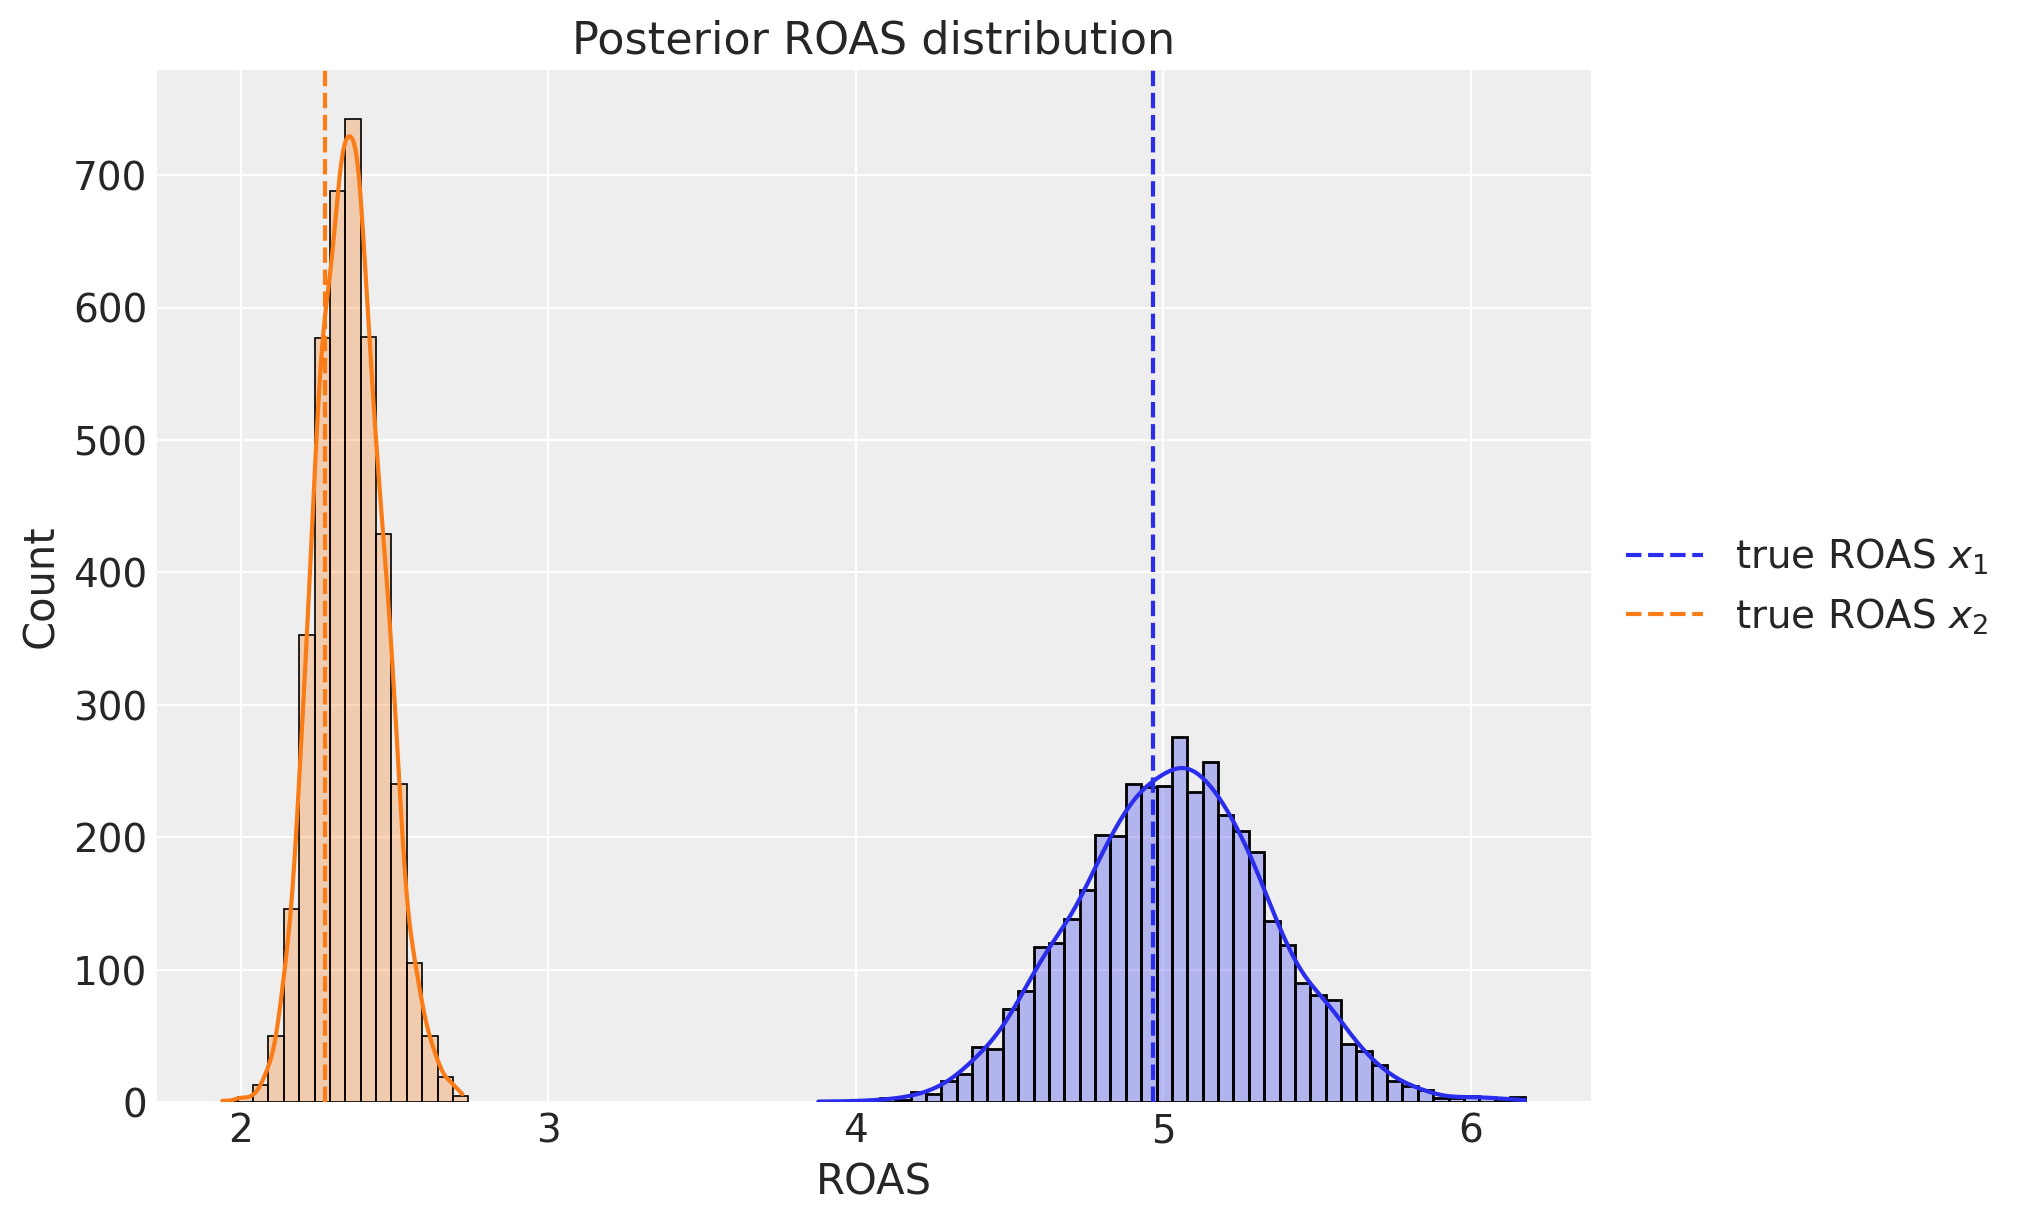

In [47]:
channel_contribution_original_scale = mmm.compute_channel_contribution_original_scale()

roas_samples = (
    channel_contribution_original_scale.stack(sample=("chain", "draw")).sum("date")
    / data[["x1", "x2"]].sum().to_numpy()[..., None]
)

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(
    roas_samples.sel(channel="x1").to_numpy(), binwidth=0.05, alpha=0.3, kde=True, ax=ax
)
sns.histplot(
    roas_samples.sel(channel="x2").to_numpy(), binwidth=0.05, alpha=0.3, kde=True, ax=ax
)
ax.axvline(x=roas_1, color="C0", linestyle="--", label=r"true ROAS $x_{1}$")
ax.axvline(x=roas_2, color="C1", linestyle="--", label=r"true ROAS $x_{2}$")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Posterior ROAS distribution", xlabel="ROAS");
